## Setup environment

In [1]:
!pip install -q "monai[nibabel, tqdm, einops, itk]==0.9.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    RandAffined,
    RandGaussianNoised,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.0
Numpy version: 1.21.4
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/sara/.local/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 7.0.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.2+cu113
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.5.1
pandas version: 1.3.5
einops version: 0.3.2
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
directory = "/home/sara/MONAI/KOMP"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/sara/MONAI/KOMP


## Setup transforms for training and validation

In [4]:
image_dim = 128
pixel_dim = 1
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(pixel_dim, pixel_dim, pixel_dim),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(image_dim, image_dim, image_dim),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        RandGaussianNoised(
            keys=['image', 'label'],
            prob=0.1, 
            mean=0,
            std=.1,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.1, 
            spatial_size=(image_dim, image_dim, image_dim),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1),
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(
            keys=["image", "label"],
            pixdim=(pixel_dim, pixel_dim, pixel_dim),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
### data_dir = "./data/"
split_JSON = "dataset_KOMP.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=74,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=18, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

## Check data shape and visualize

image shape: torch.Size([1, 209, 250, 400]), label shape: torch.Size([1, 209, 250, 400])


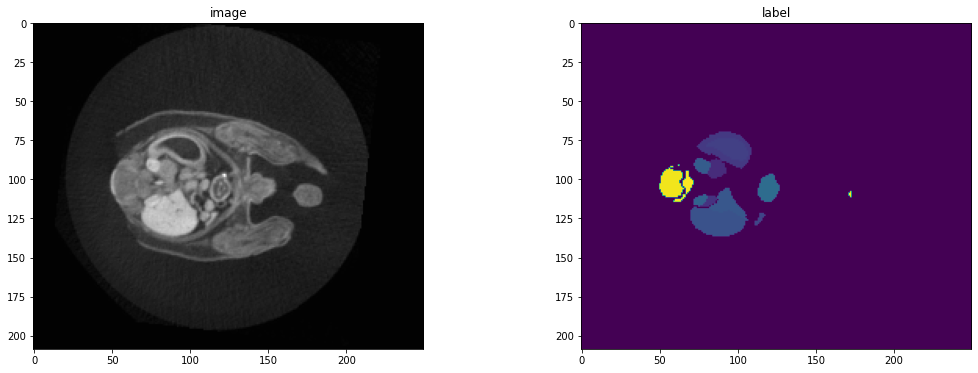

In [6]:
slice_map = {
    "AAMN_N305_10.nii.gz": 100,
    "AAMN_N305_14.nii.gz": 150,
    "AAMN_N305_15.nii.gz": 160,
    "AAMN_N305_17.nii.gz": 125,
    "AAMN_N305_23.nii.gz": 175,
    "AAMN_N305_26.nii.gz": 140,
}
case_num = 5
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [7]:
torch.set_num_threads(24)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=51,
    img_size=(image_dim, image_dim, image_dim),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)

### Execute PyTorch training process

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (image_dim, image_dim, image_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model_largePatch.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best



In [9]:
max_iterations = 60000
eval_num = 500
post_label = AsDiscrete(to_onehot=51)
post_pred = AsDiscrete(argmax=True, to_onehot=51)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [10]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_largePatch.pth")))

Training (73 / 80000 Steps) (loss=4.60467): 100%|█| 74/74 [01:20<00:00,  1.09s/i
Training (147 / 80000 Steps) (loss=4.41631): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (221 / 80000 Steps) (loss=4.32701): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (295 / 80000 Steps) (loss=4.27802): 100%|█| 74/74 [01:16<00:00,  1.04s/
Training (369 / 80000 Steps) (loss=4.30406): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (443 / 80000 Steps) (loss=4.13418): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (500 / 80000 Steps) (loss=4.10320):  76%|▊| 56/74 [00:58<00:18,  1.01s/
Validate (444 / 10 Steps) (dice=0.02218): 100%|█| 17/17 [00:26<00:00,  1.55s/it]
Training (500 / 80000 Steps) (loss=4.10320):  77%|▊| 57/74 [01:25<02:32,  9.00s/

Model Was Saved ! Current Best Avg. Dice: 0.022110967075123507 Current Avg. Dice: 0.022110967075123507


Training (517 / 80000 Steps) (loss=4.03632): 100%|█| 74/74 [01:42<00:00,  1.39s/
Training (591 / 80000 Steps) (loss=4.02872): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (665 / 80000 Steps) (loss=3.91713): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (739 / 80000 Steps) (loss=3.83418): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (813 / 80000 Steps) (loss=3.79882): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (887 / 80000 Steps) (loss=3.72600): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (961 / 80000 Steps) (loss=3.65856): 100%|█| 74/74 [01:16<00:00,  1.03s/
Training (1000 / 80000 Steps) (loss=3.60562):  51%|▌| 38/74 [00:40<00:36,  1.01s
Validate (962 / 10 Steps) (dice=0.02165): 100%|█| 17/17 [00:25<00:00,  1.53s/it]
Training (1000 / 80000 Steps) (loss=3.60562):  53%|▌| 39/74 [01:06<05:07,  8.79s

Model Was Not Saved ! Current Best Avg. Dice: 0.022110967075123507 Current Avg. Dice: 0.021571373895687217


Training (1035 / 80000 Steps) (loss=3.58594): 100%|█| 74/74 [01:42<00:00,  1.38s
Training (1109 / 80000 Steps) (loss=3.51104): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1183 / 80000 Steps) (loss=3.41394): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1257 / 80000 Steps) (loss=3.36798): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1331 / 80000 Steps) (loss=3.31463): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1405 / 80000 Steps) (loss=3.29002): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1479 / 80000 Steps) (loss=3.16948): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1500 / 80000 Steps) (loss=3.14758):  27%|▎| 20/74 [00:22<00:54,  1.01s
Validate (1480 / 10 Steps) (dice=0.02386):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (1480 / 10 Steps) (dice=0.02386):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (1480 / 10 Steps) (dice=0.02396):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (1480 / 10 Steps) (dice=0.02396):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (1480 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.02370412735378041 Current Avg. Dice: 0.02370412735378041


Training (1553 / 80000 Steps) (loss=3.07628): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (1627 / 80000 Steps) (loss=3.04122): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (1701 / 80000 Steps) (loss=3.02500): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (1775 / 80000 Steps) (loss=3.11355): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (1849 / 80000 Steps) (loss=2.88117): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (1923 / 80000 Steps) (loss=2.79159): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (1997 / 80000 Steps) (loss=2.74594): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2000 / 80000 Steps) (loss=2.72533):   3%| | 2/74 [00:04<02:00,  1.67s/
Validate (1998 / 10 Steps) (dice=0.02498):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (1998 / 10 Steps) (dice=0.02498):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (1998 / 10 Steps) (dice=0.02501):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (1998 / 10 Steps) (dice=0.02501):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (1998 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.02473570658441852 Current Avg. Dice: 0.02473570658441852


Training (2071 / 80000 Steps) (loss=2.63773): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (2145 / 80000 Steps) (loss=2.59501): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2219 / 80000 Steps) (loss=2.52153): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2293 / 80000 Steps) (loss=2.52306): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (2367 / 80000 Steps) (loss=2.43440): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2441 / 80000 Steps) (loss=2.42023): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2500 / 80000 Steps) (loss=2.34401):  78%|▊| 58/74 [01:00<00:16,  1.02s
Validate (2442 / 10 Steps) (dice=0.02434):  53%|▌| 9/17 [00:15<00:12,  1.51s/it]
Validate (2442 / 10 Steps) (dice=0.02434):  59%|▌| 10/17 [00:15<00:10,  1.50s/it
Validate (2442 / 10 Steps) (dice=0.02443):  59%|▌| 10/17 [00:17<00:10,  1.50s/it
Validate (2442 / 10 Steps) (dice=0.02443):  65%|▋| 11/17 [00:17<00:08,  1.50s/it
Validate (2442 / 10 Steps) (dice=0.02438):  65%|▋| 11/17 [00:18<00:08,  1.50s/it
Validate (2442 / 10 Steps) (

Model Was Not Saved ! Current Best Avg. Dice: 0.02473570658441852 Current Avg. Dice: 0.024257905781269073


Training (2515 / 80000 Steps) (loss=2.31954): 100%|█| 74/74 [01:42<00:00,  1.38s
Training (2589 / 80000 Steps) (loss=2.29372): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (2663 / 80000 Steps) (loss=2.29025): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2737 / 80000 Steps) (loss=2.15897): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2811 / 80000 Steps) (loss=2.14512): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (2885 / 80000 Steps) (loss=2.12556): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (2959 / 80000 Steps) (loss=2.07964): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3000 / 80000 Steps) (loss=2.01273):  54%|▌| 40/74 [00:42<00:34,  1.01s
Validate (2960 / 10 Steps) (dice=0.02899):  53%|▌| 9/17 [00:15<00:12,  1.50s/it]
Validate (2960 / 10 Steps) (dice=0.02899):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (2960 / 10 Steps) (dice=0.02924):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (2960 / 10 Steps) (dice=0.02924):  65%|▋| 11/17 [00:16<00:08,  1.49s/it
Validate (2960 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.028972395093125457 Current Avg. Dice: 0.028972395093125457


Training (3033 / 80000 Steps) (loss=2.03607): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (3107 / 80000 Steps) (loss=1.98886): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3181 / 80000 Steps) (loss=1.92156): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3255 / 80000 Steps) (loss=1.95344): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (3329 / 80000 Steps) (loss=1.97881): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (3403 / 80000 Steps) (loss=1.84507): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (3477 / 80000 Steps) (loss=1.82330): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (3500 / 80000 Steps) (loss=1.80272):  30%|▎| 22/74 [00:24<00:52,  1.01s
Validate (3478 / 10 Steps) (dice=0.04423):  53%|▌| 9/17 [00:15<00:11,  1.50s/it]
Validate (3478 / 10 Steps) (dice=0.04423):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (3478 / 10 Steps) (dice=0.04444):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (3478 / 10 Steps) (dice=0.04444):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (3478 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.04406641577096546 Current Avg. Dice: 0.04406641577096546


Training (3551 / 80000 Steps) (loss=1.87816): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (3625 / 80000 Steps) (loss=1.79962): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3699 / 80000 Steps) (loss=1.80972): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3773 / 80000 Steps) (loss=1.77544): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3847 / 80000 Steps) (loss=1.67581): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3921 / 80000 Steps) (loss=1.65261): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (3995 / 80000 Steps) (loss=1.67057): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4000 / 80000 Steps) (loss=1.72650):   5%| | 4/74 [00:06<01:22,  1.18s/
Validate (3996 / 10 Steps) (dice=0.04889):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (3996 / 10 Steps) (dice=0.04889):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (3996 / 10 Steps) (dice=0.04882):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (3996 / 10 Steps) (dice=0.04882):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (3996 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.04765441312509425 Current Avg. Dice: 0.04765441312509425


Training (4069 / 80000 Steps) (loss=1.72271): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (4143 / 80000 Steps) (loss=1.57083): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4217 / 80000 Steps) (loss=1.51181): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4291 / 80000 Steps) (loss=1.65966): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4365 / 80000 Steps) (loss=1.56954): 100%|█| 74/74 [01:15<00:00,  1.03s
Training (4439 / 80000 Steps) (loss=1.51099): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4500 / 80000 Steps) (loss=1.50363):  81%|▊| 60/74 [01:03<00:14,  1.01s
Validate (4440 / 10 Steps) (dice=0.05481):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (4440 / 10 Steps) (dice=0.05481):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (4440 / 10 Steps) (dice=0.05489):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (4440 / 10 Steps) (dice=0.05489):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (4440 / 10 Steps) (dice=0.05472):  65%|▋| 11/17 [00:18<00:08,  1.48s/it
Validate (4440 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.054314542561769485 Current Avg. Dice: 0.054314542561769485


Training (4513 / 80000 Steps) (loss=1.47333): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (4587 / 80000 Steps) (loss=1.51720): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4661 / 80000 Steps) (loss=1.50104): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4735 / 80000 Steps) (loss=1.51272): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (4809 / 80000 Steps) (loss=1.47223): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4883 / 80000 Steps) (loss=1.40591): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (4957 / 80000 Steps) (loss=1.52776): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (5000 / 80000 Steps) (loss=1.48638):  57%|▌| 42/74 [00:44<00:32,  1.01s
Validate (4958 / 10 Steps) (dice=0.08378):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (4958 / 10 Steps) (dice=0.08378):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (4958 / 10 Steps) (dice=0.08379):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (4958 / 10 Steps) (dice=0.08379):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (4958 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.08325244880774442 Current Avg. Dice: 0.08325244880774442


Training (5031 / 80000 Steps) (loss=1.35551): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (5105 / 80000 Steps) (loss=1.37205): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5179 / 80000 Steps) (loss=1.48105): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5253 / 80000 Steps) (loss=1.34524): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5327 / 80000 Steps) (loss=1.29047): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5401 / 80000 Steps) (loss=1.31644): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5475 / 80000 Steps) (loss=1.34987): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5500 / 80000 Steps) (loss=1.39710):  32%|▎| 24/74 [00:26<00:50,  1.01s
Validate (5476 / 10 Steps) (dice=0.13018):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (5476 / 10 Steps) (dice=0.13018):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (5476 / 10 Steps) (dice=0.13045):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (5476 / 10 Steps) (dice=0.13045):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (5476 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.130294572781114 Current Avg. Dice: 0.130294572781114


Training (5549 / 80000 Steps) (loss=1.35241): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (5623 / 80000 Steps) (loss=1.42808): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5697 / 80000 Steps) (loss=1.25732): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5771 / 80000 Steps) (loss=1.31781): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (5845 / 80000 Steps) (loss=1.29090): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (5919 / 80000 Steps) (loss=1.43235): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (5993 / 80000 Steps) (loss=1.20279): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6000 / 80000 Steps) (loss=1.24135):   8%| | 6/74 [00:08<01:12,  1.07s/
Validate (5994 / 10 Steps) (dice=0.14513):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (5994 / 10 Steps) (dice=0.14513):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (5994 / 10 Steps) (dice=0.14594):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (5994 / 10 Steps) (dice=0.14594):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (5994 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.14479413628578186 Current Avg. Dice: 0.14479413628578186


Training (6067 / 80000 Steps) (loss=1.20852): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (6141 / 80000 Steps) (loss=1.19055): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6215 / 80000 Steps) (loss=1.24267): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6289 / 80000 Steps) (loss=1.29439): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6363 / 80000 Steps) (loss=1.18863): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (6437 / 80000 Steps) (loss=1.41356): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6500 / 80000 Steps) (loss=1.17690):  84%|▊| 62/74 [01:05<00:12,  1.01s
Validate (6438 / 10 Steps) (dice=0.15040):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (6438 / 10 Steps) (dice=0.15040):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (6438 / 10 Steps) (dice=0.15078):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (6438 / 10 Steps) (dice=0.15078):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (6438 / 10 Steps) (dice=0.15179):  65%|▋| 11/17 [00:18<00:08,  1.48s/it
Validate (6438 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.15116693167125478 Current Avg. Dice: 0.15116693167125478


Training (6511 / 80000 Steps) (loss=1.24498): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (6585 / 80000 Steps) (loss=1.21607): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6659 / 80000 Steps) (loss=1.30148): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6733 / 80000 Steps) (loss=1.29441): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6807 / 80000 Steps) (loss=1.14476): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6881 / 80000 Steps) (loss=1.26758): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (6955 / 80000 Steps) (loss=1.17245): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (7000 / 80000 Steps) (loss=1.20167):  59%|▌| 44/74 [00:46<00:30,  1.01s
Validate (6956 / 10 Steps) (dice=0.17062):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (6956 / 10 Steps) (dice=0.17062):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (6956 / 10 Steps) (dice=0.17091):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (6956 / 10 Steps) (dice=0.17091):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (6956 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.17101330441587112 Current Avg. Dice: 0.17101330441587112


Training (7029 / 80000 Steps) (loss=1.37940): 100%|█| 74/74 [01:42<00:00,  1.38s
Training (7103 / 80000 Steps) (loss=1.32768): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7177 / 80000 Steps) (loss=1.15048): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7251 / 80000 Steps) (loss=1.17476): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7325 / 80000 Steps) (loss=1.34840): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7399 / 80000 Steps) (loss=1.15055): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7473 / 80000 Steps) (loss=1.13843): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7500 / 80000 Steps) (loss=1.14020):  35%|▎| 26/74 [00:28<00:48,  1.01s
Validate (7474 / 10 Steps) (dice=0.18948):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (7474 / 10 Steps) (dice=0.18948):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (7474 / 10 Steps) (dice=0.18976):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (7474 / 10 Steps) (dice=0.18976):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (7474 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.18987862502827363 Current Avg. Dice: 0.18987862502827363


Training (7547 / 80000 Steps) (loss=1.09266): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (7621 / 80000 Steps) (loss=1.09153): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7695 / 80000 Steps) (loss=1.14019): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7769 / 80000 Steps) (loss=1.30432): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7843 / 80000 Steps) (loss=1.26625): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7917 / 80000 Steps) (loss=1.09260): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (7991 / 80000 Steps) (loss=1.18597): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8000 / 80000 Steps) (loss=1.14592):  11%| | 8/74 [00:10<01:08,  1.04s/
Validate (7992 / 10 Steps) (dice=0.23205):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (7992 / 10 Steps) (dice=0.23205):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (7992 / 10 Steps) (dice=0.23266):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (7992 / 10 Steps) (dice=0.23266):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (7992 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.2328175919897416 Current Avg. Dice: 0.2328175919897416


Training (8065 / 80000 Steps) (loss=1.08506): 100%|█| 74/74 [01:42<00:00,  1.38s
Training (8139 / 80000 Steps) (loss=1.08426): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8213 / 80000 Steps) (loss=1.22711): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (8287 / 80000 Steps) (loss=1.17367): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8361 / 80000 Steps) (loss=1.10370): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8435 / 80000 Steps) (loss=1.08950): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8500 / 80000 Steps) (loss=1.07952):  86%|▊| 64/74 [01:07<00:10,  1.01s
Validate (8436 / 10 Steps) (dice=0.24626):  53%|▌| 9/17 [00:15<00:11,  1.50s/it]
Validate (8436 / 10 Steps) (dice=0.24626):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (8436 / 10 Steps) (dice=0.24667):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (8436 / 10 Steps) (dice=0.24667):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (8436 / 10 Steps) (dice=0.24785):  65%|▋| 11/17 [00:18<00:08,  1.48s/it
Validate (8436 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.24743779354235707 Current Avg. Dice: 0.24743779354235707


Training (8509 / 80000 Steps) (loss=1.12257): 100%|█| 74/74 [01:43<00:00,  1.39s
Training (8583 / 80000 Steps) (loss=1.17751): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8657 / 80000 Steps) (loss=1.06046): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8731 / 80000 Steps) (loss=1.12703): 100%|█| 74/74 [01:16<00:00,  1.04s
Training (8805 / 80000 Steps) (loss=1.14975): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8879 / 80000 Steps) (loss=1.09113): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (8953 / 80000 Steps) (loss=1.07139): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9000 / 80000 Steps) (loss=1.11909):  62%|▌| 46/74 [00:48<00:28,  1.01s
Validate (8954 / 10 Steps) (dice=0.26240):  53%|▌| 9/17 [00:15<00:11,  1.50s/it]
Validate (8954 / 10 Steps) (dice=0.26240):  59%|▌| 10/17 [00:15<00:10,  1.49s/it
Validate (8954 / 10 Steps) (dice=0.26284):  59%|▌| 10/17 [00:16<00:10,  1.49s/it
Validate (8954 / 10 Steps) (dice=0.26284):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (8954 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.2630251348018646 Current Avg. Dice: 0.2630251348018646


Training (9027 / 80000 Steps) (loss=1.05345): 100%|█| 74/74 [01:42<00:00,  1.39s
Training (9101 / 80000 Steps) (loss=1.06119): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9175 / 80000 Steps) (loss=1.10366): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9249 / 80000 Steps) (loss=1.20479): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9323 / 80000 Steps) (loss=1.17325): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9397 / 80000 Steps) (loss=1.03535): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9471 / 80000 Steps) (loss=1.00052): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9500 / 80000 Steps) (loss=1.20283):  38%|▍| 28/74 [00:31<00:46,  1.01s
Validate (9472 / 10 Steps) (dice=0.26940):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (9472 / 10 Steps) (dice=0.26940):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (9472 / 10 Steps) (dice=0.27127):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (9472 / 10 Steps) (dice=0.27127):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (9472 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.2720581678783192 Current Avg. Dice: 0.2720581678783192


Training (9545 / 80000 Steps) (loss=1.12606): 100%|█| 74/74 [01:43<00:00,  1.39s
Training (9619 / 80000 Steps) (loss=1.08256): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9693 / 80000 Steps) (loss=1.13065): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9767 / 80000 Steps) (loss=1.04593): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9841 / 80000 Steps) (loss=1.02891): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9915 / 80000 Steps) (loss=1.11897): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (9989 / 80000 Steps) (loss=1.00268): 100%|█| 74/74 [01:16<00:00,  1.03s
Training (10000 / 80000 Steps) (loss=1.11260):  14%|▏| 10/74 [00:12<01:05,  1.03
Validate (9990 / 10 Steps) (dice=0.30134):  53%|▌| 9/17 [00:15<00:11,  1.49s/it]
Validate (9990 / 10 Steps) (dice=0.30134):  59%|▌| 10/17 [00:15<00:10,  1.48s/it
Validate (9990 / 10 Steps) (dice=0.30252):  59%|▌| 10/17 [00:16<00:10,  1.48s/it
Validate (9990 / 10 Steps) (dice=0.30252):  65%|▋| 11/17 [00:16<00:08,  1.48s/it
Validate (9990 / 10 Steps) (

Model Was Saved ! Current Best Avg. Dice: 0.3029012574869044 Current Avg. Dice: 0.3029012574869044


Training (10063 / 80000 Steps) (loss=1.17348): 100%|█| 74/74 [01:42<00:00,  1.39
Training (10137 / 80000 Steps) (loss=1.03676): 100%|█| 74/74 [01:16<00:00,  1.04
Training (10211 / 80000 Steps) (loss=1.02353): 100%|█| 74/74 [01:16<00:00,  1.04
Training (10285 / 80000 Steps) (loss=1.11268): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10359 / 80000 Steps) (loss=1.16792): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10433 / 80000 Steps) (loss=1.03269): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10500 / 80000 Steps) (loss=0.97609):  89%|▉| 66/74 [01:08<00:08,  1.01
Validate (10434 / 10 Steps) (dice=0.35006):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (10434 / 10 Steps) (dice=0.35006):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (10434 / 10 Steps) (dice=0.34562):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (10434 / 10 Steps) (dice=0.34562):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (10434 / 10 Steps) (dice=0.34535):  12%| | 2/17 [00:05<00:26,  1.74s/it
Validate (10434 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.33909566612804637 Current Avg. Dice: 0.33909566612804637


Training (10507 / 80000 Steps) (loss=1.97780): 100%|█| 74/74 [01:42<00:00,  1.38
Training (10581 / 80000 Steps) (loss=1.06431): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10655 / 80000 Steps) (loss=0.99282): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10729 / 80000 Steps) (loss=1.05724): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10803 / 80000 Steps) (loss=1.02583): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10877 / 80000 Steps) (loss=1.03480): 100%|█| 74/74 [01:16<00:00,  1.03
Training (10951 / 80000 Steps) (loss=1.09860): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11000 / 80000 Steps) (loss=0.96320):  65%|▋| 48/74 [00:50<00:26,  1.01
Validate (10952 / 10 Steps) (dice=0.36502):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (10952 / 10 Steps) (dice=0.36502):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (10952 / 10 Steps) (dice=0.35847):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (10952 / 10 Steps) (dice=0.35847):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (10952 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3543965308105244 Current Avg. Dice: 0.3543965308105244


Training (11025 / 80000 Steps) (loss=1.14522): 100%|█| 74/74 [01:42<00:00,  1.38
Training (11099 / 80000 Steps) (loss=1.05076): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11173 / 80000 Steps) (loss=1.01420): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11247 / 80000 Steps) (loss=1.07784): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11321 / 80000 Steps) (loss=1.01683): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11395 / 80000 Steps) (loss=1.78399): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11469 / 80000 Steps) (loss=1.10058): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11500 / 80000 Steps) (loss=1.09645):  41%|▍| 30/74 [00:32<00:44,  1.01
Validate (11470 / 10 Steps) (dice=0.37518):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (11470 / 10 Steps) (dice=0.37518):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (11470 / 10 Steps) (dice=0.36755):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (11470 / 10 Steps) (dice=0.36755):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (11470 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3655939908588634 Current Avg. Dice: 0.3655939908588634


Training (11543 / 80000 Steps) (loss=0.95315): 100%|█| 74/74 [01:42<00:00,  1.38
Training (11617 / 80000 Steps) (loss=1.04876): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11691 / 80000 Steps) (loss=1.05958): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11765 / 80000 Steps) (loss=1.07237): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11839 / 80000 Steps) (loss=1.08815): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11913 / 80000 Steps) (loss=1.03144): 100%|█| 74/74 [01:16<00:00,  1.03
Training (11987 / 80000 Steps) (loss=1.05388): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12000 / 80000 Steps) (loss=1.06244):  16%|▏| 12/74 [00:14<01:03,  1.02
Validate (11988 / 10 Steps) (dice=0.37754):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (11988 / 10 Steps) (dice=0.37754):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (11988 / 10 Steps) (dice=0.37076):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (11988 / 10 Steps) (dice=0.37076):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (11988 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.3680492972626406 Current Avg. Dice: 0.3680492972626406


Training (12061 / 80000 Steps) (loss=0.96086): 100%|█| 74/74 [01:42<00:00,  1.39
Training (12135 / 80000 Steps) (loss=0.95121): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12209 / 80000 Steps) (loss=0.92590): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12283 / 80000 Steps) (loss=1.00175): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12357 / 80000 Steps) (loss=0.98508): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12431 / 80000 Steps) (loss=1.10297): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12500 / 80000 Steps) (loss=1.04890):  92%|▉| 68/74 [01:11<00:06,  1.01
Validate (12432 / 10 Steps) (dice=0.37615):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (12432 / 10 Steps) (dice=0.37615):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (12432 / 10 Steps) (dice=0.37334):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (12432 / 10 Steps) (dice=0.37334):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (12432 / 10 Steps) (dice=0.37541):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (12432 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.370475733981413 Current Avg. Dice: 0.370475733981413


Training (12505 / 80000 Steps) (loss=1.47528): 100%|█| 74/74 [01:43<00:00,  1.39
Training (12579 / 80000 Steps) (loss=1.03380): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12653 / 80000 Steps) (loss=0.98986): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12727 / 80000 Steps) (loss=0.92070): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12801 / 80000 Steps) (loss=0.99213): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12875 / 80000 Steps) (loss=0.98386): 100%|█| 74/74 [01:16<00:00,  1.03
Training (12949 / 80000 Steps) (loss=0.91543): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13000 / 80000 Steps) (loss=1.82863):  68%|▋| 50/74 [00:53<00:24,  1.01
Validate (12950 / 10 Steps) (dice=0.41806):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (12950 / 10 Steps) (dice=0.41806):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (12950 / 10 Steps) (dice=0.40907):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (12950 / 10 Steps) (dice=0.40907):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (12950 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.4064619944376104 Current Avg. Dice: 0.4064619944376104


Training (13023 / 80000 Steps) (loss=0.93352): 100%|█| 74/74 [01:43<00:00,  1.39
Training (13097 / 80000 Steps) (loss=0.94103): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13171 / 80000 Steps) (loss=0.97997): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13245 / 80000 Steps) (loss=1.01258): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13319 / 80000 Steps) (loss=1.00294): 100%|█| 74/74 [01:16<00:00,  1.04
Training (13393 / 80000 Steps) (loss=0.98379): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13467 / 80000 Steps) (loss=0.92002): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13500 / 80000 Steps) (loss=0.93340):  43%|▍| 32/74 [00:34<00:42,  1.01
Validate (13468 / 10 Steps) (dice=0.43523):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (13468 / 10 Steps) (dice=0.43523):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (13468 / 10 Steps) (dice=0.42626):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (13468 / 10 Steps) (dice=0.42626):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (13468 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.42555469274520874 Current Avg. Dice: 0.42555469274520874


Training (13541 / 80000 Steps) (loss=1.02719): 100%|█| 74/74 [01:42<00:00,  1.39
Training (13615 / 80000 Steps) (loss=0.92664): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13689 / 80000 Steps) (loss=0.92432): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13763 / 80000 Steps) (loss=0.94635): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13837 / 80000 Steps) (loss=0.98557): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13911 / 80000 Steps) (loss=0.91329): 100%|█| 74/74 [01:16<00:00,  1.03
Training (13985 / 80000 Steps) (loss=0.98002): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14000 / 80000 Steps) (loss=0.90451):  19%|▏| 14/74 [00:16<01:00,  1.01
Validate (13986 / 10 Steps) (dice=0.43483):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (13986 / 10 Steps) (dice=0.43483):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (13986 / 10 Steps) (dice=0.42856):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (13986 / 10 Steps) (dice=0.42856):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (13986 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.4269535541534424 Current Avg. Dice: 0.4269535541534424


Training (14059 / 80000 Steps) (loss=0.94591): 100%|█| 74/74 [01:42<00:00,  1.39
Training (14133 / 80000 Steps) (loss=0.90529): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14207 / 80000 Steps) (loss=1.90236): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14281 / 80000 Steps) (loss=0.97673): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14355 / 80000 Steps) (loss=1.01367): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14429 / 80000 Steps) (loss=0.94283): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14500 / 80000 Steps) (loss=0.99091):  95%|▉| 70/74 [01:13<00:04,  1.01
Validate (14430 / 10 Steps) (dice=0.44698):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (14430 / 10 Steps) (dice=0.44698):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (14430 / 10 Steps) (dice=0.44159):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (14430 / 10 Steps) (dice=0.44159):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (14430 / 10 Steps) (dice=0.44385):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (14430 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.4379103148684782 Current Avg. Dice: 0.4379103148684782


Training (14503 / 80000 Steps) (loss=0.93864): 100%|█| 74/74 [01:42<00:00,  1.39
Training (14577 / 80000 Steps) (loss=0.90648): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14651 / 80000 Steps) (loss=0.89132): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14725 / 80000 Steps) (loss=0.89006): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14799 / 80000 Steps) (loss=0.92398): 100%|█| 74/74 [01:15<00:00,  1.03
Training (14873 / 80000 Steps) (loss=0.92735): 100%|█| 74/74 [01:16<00:00,  1.03
Training (14947 / 80000 Steps) (loss=0.98548): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15000 / 80000 Steps) (loss=1.02094):  70%|▋| 52/74 [00:54<00:22,  1.01
Validate (14948 / 10 Steps) (dice=0.46277):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (14948 / 10 Steps) (dice=0.46277):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (14948 / 10 Steps) (dice=0.45822):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (14948 / 10 Steps) (dice=0.45822):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (14948 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.4540504655417274 Current Avg. Dice: 0.4540504655417274


Training (15021 / 80000 Steps) (loss=0.87470): 100%|█| 74/74 [01:42<00:00,  1.38
Training (15095 / 80000 Steps) (loss=0.95698): 100%|█| 74/74 [01:16<00:00,  1.04
Training (15169 / 80000 Steps) (loss=0.96575): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15243 / 80000 Steps) (loss=0.81066): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15317 / 80000 Steps) (loss=0.93760): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15391 / 80000 Steps) (loss=0.90459): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15465 / 80000 Steps) (loss=0.95014): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15500 / 80000 Steps) (loss=0.99814):  46%|▍| 34/74 [00:37<00:40,  1.01
Validate (15466 / 10 Steps) (dice=0.46564):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (15466 / 10 Steps) (dice=0.46564):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (15466 / 10 Steps) (dice=0.46181):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (15466 / 10 Steps) (dice=0.46181):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (15466 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.45801694252911734 Current Avg. Dice: 0.45801694252911734


Training (15539 / 80000 Steps) (loss=0.85467): 100%|█| 74/74 [01:42<00:00,  1.39
Training (15613 / 80000 Steps) (loss=0.90471): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15687 / 80000 Steps) (loss=0.92640): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15761 / 80000 Steps) (loss=0.95947): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15835 / 80000 Steps) (loss=0.93792): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15909 / 80000 Steps) (loss=0.85619): 100%|█| 74/74 [01:16<00:00,  1.03
Training (15983 / 80000 Steps) (loss=1.02857): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16000 / 80000 Steps) (loss=0.95472):  22%|▏| 16/74 [00:18<00:58,  1.01
Validate (15984 / 10 Steps) (dice=0.47865):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (15984 / 10 Steps) (dice=0.47865):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (15984 / 10 Steps) (dice=0.46903):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (15984 / 10 Steps) (dice=0.46903):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (15984 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.45801694252911734 Current Avg. Dice: 0.45631687255466685


Training (16057 / 80000 Steps) (loss=0.91933): 100%|█| 74/74 [01:42<00:00,  1.39
Training (16131 / 80000 Steps) (loss=0.97990): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16205 / 80000 Steps) (loss=0.87736): 100%|█| 74/74 [01:15<00:00,  1.03
Training (16279 / 80000 Steps) (loss=0.89278): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16353 / 80000 Steps) (loss=0.89263): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16427 / 80000 Steps) (loss=0.83635): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16500 / 80000 Steps) (loss=0.82951):  97%|▉| 72/74 [01:15<00:02,  1.01
Validate (16428 / 10 Steps) (dice=0.50186):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (16428 / 10 Steps) (dice=0.50186):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (16428 / 10 Steps) (dice=0.49604):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (16428 / 10 Steps) (dice=0.49604):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (16428 / 10 Steps) (dice=0.50045):  12%| | 2/17 [00:05<00:26,  1.74s/it
Validate (16428 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.4933880585081437 Current Avg. Dice: 0.4933880585081437


Training (16501 / 80000 Steps) (loss=0.90500): 100%|█| 74/74 [01:42<00:00,  1.39
Training (16575 / 80000 Steps) (loss=0.85931): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16649 / 80000 Steps) (loss=0.80274): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16723 / 80000 Steps) (loss=0.86221): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16797 / 80000 Steps) (loss=0.88395): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16871 / 80000 Steps) (loss=0.79993): 100%|█| 74/74 [01:16<00:00,  1.03
Training (16945 / 80000 Steps) (loss=0.83486): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17000 / 80000 Steps) (loss=0.92432):  73%|▋| 54/74 [00:57<00:20,  1.01
Validate (16946 / 10 Steps) (dice=0.51590):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (16946 / 10 Steps) (dice=0.51590):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (16946 / 10 Steps) (dice=0.50718):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (16946 / 10 Steps) (dice=0.50718):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (16946 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.5043535828590393 Current Avg. Dice: 0.5043535828590393


Training (17019 / 80000 Steps) (loss=0.90466): 100%|█| 74/74 [01:42<00:00,  1.39
Training (17093 / 80000 Steps) (loss=0.91899): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17167 / 80000 Steps) (loss=0.85319): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17241 / 80000 Steps) (loss=0.78730): 100%|█| 74/74 [01:16<00:00,  1.04
Training (17315 / 80000 Steps) (loss=0.79329): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17389 / 80000 Steps) (loss=0.83957): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17463 / 80000 Steps) (loss=0.89666): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17500 / 80000 Steps) (loss=0.88398):  49%|▍| 36/74 [00:39<00:38,  1.01
Validate (17464 / 10 Steps) (dice=0.56371):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (17464 / 10 Steps) (dice=0.56371):   6%| | 1/17 [00:02<00:33,  2.06s/it
Validate (17464 / 10 Steps) (dice=0.54986):   6%| | 1/17 [00:03<00:33,  2.06s/it
Validate (17464 / 10 Steps) (dice=0.54986):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (17464 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.547486869727864 Current Avg. Dice: 0.547486869727864


Training (17537 / 80000 Steps) (loss=0.81838): 100%|█| 74/74 [01:42<00:00,  1.39
Training (17611 / 80000 Steps) (loss=0.88532): 100%|█| 74/74 [01:16<00:00,  1.04
Training (17685 / 80000 Steps) (loss=0.87064): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17759 / 80000 Steps) (loss=0.91066): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17833 / 80000 Steps) (loss=0.84395): 100%|█| 74/74 [01:16<00:00,  1.03
Training (17907 / 80000 Steps) (loss=0.85169): 100%|█| 74/74 [01:16<00:00,  1.04
Training (17981 / 80000 Steps) (loss=0.82858): 100%|█| 74/74 [01:16<00:00,  1.04
Training (18000 / 80000 Steps) (loss=0.86080):  24%|▏| 18/74 [00:20<00:56,  1.01
Validate (17982 / 10 Steps) (dice=0.58308):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (17982 / 10 Steps) (dice=0.58308):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (17982 / 10 Steps) (dice=0.56926):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (17982 / 10 Steps) (dice=0.56926):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (17982 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.5644718057969037 Current Avg. Dice: 0.5644718057969037


Training (18055 / 80000 Steps) (loss=0.88394): 100%|█| 74/74 [01:42<00:00,  1.39
Training (18129 / 80000 Steps) (loss=0.88645): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18203 / 80000 Steps) (loss=0.84107): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18277 / 80000 Steps) (loss=0.85407): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18351 / 80000 Steps) (loss=0.83504): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18425 / 80000 Steps) (loss=0.90573): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18499 / 80000 Steps) (loss=0.90653): 100%|█| 74/74 [01:16<00:00,  1.03
Validate (18500 / 10 Steps) (dice=0.60783):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (18500 / 10 Steps) (dice=0.60783):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (18500 / 10 Steps) (dice=0.59714):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (18500 / 10 Steps) (dice=0.59714):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (18500 / 10 Steps) (dice=0.60417):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (18500 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.5918313229785246 Current Avg. Dice: 0.5918313229785246


Training (18573 / 80000 Steps) (loss=0.86030): 100%|█| 74/74 [01:42<00:00,  1.39
Training (18647 / 80000 Steps) (loss=0.84308): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18721 / 80000 Steps) (loss=0.80966): 100%|█| 74/74 [01:16<00:00,  1.04
Training (18795 / 80000 Steps) (loss=0.86709): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18869 / 80000 Steps) (loss=0.81498): 100%|█| 74/74 [01:16<00:00,  1.03
Training (18943 / 80000 Steps) (loss=0.89660): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19000 / 80000 Steps) (loss=0.88660):  76%|▊| 56/74 [00:58<00:18,  1.01
Validate (18944 / 10 Steps) (dice=0.63451):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (18944 / 10 Steps) (dice=0.63451):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (18944 / 10 Steps) (dice=0.62600):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (18944 / 10 Steps) (dice=0.62600):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (18944 / 10 Steps) (dice=0.63381):  12%| | 2/17 [00:05<00:25,  1.73s/it
Validate (18944 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.6232910997727338 Current Avg. Dice: 0.6232910997727338


Training (19017 / 80000 Steps) (loss=0.75535): 100%|█| 74/74 [01:42<00:00,  1.38
Training (19091 / 80000 Steps) (loss=0.74707): 100%|█| 74/74 [01:16<00:00,  1.04
Training (19165 / 80000 Steps) (loss=0.86632): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19239 / 80000 Steps) (loss=0.75729): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19313 / 80000 Steps) (loss=0.78238): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19387 / 80000 Steps) (loss=0.90930): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19461 / 80000 Steps) (loss=0.81634): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19500 / 80000 Steps) (loss=0.88358):  51%|▌| 38/74 [00:40<00:36,  1.01
Validate (19462 / 10 Steps) (dice=0.65895):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (19462 / 10 Steps) (dice=0.65895):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (19462 / 10 Steps) (dice=0.64630):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (19462 / 10 Steps) (dice=0.64630):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (19462 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.6362296412972843 Current Avg. Dice: 0.6362296412972843


Training (19535 / 80000 Steps) (loss=0.77183): 100%|█| 74/74 [01:42<00:00,  1.39
Training (19609 / 80000 Steps) (loss=0.83357): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19683 / 80000 Steps) (loss=0.84556): 100%|█| 74/74 [01:16<00:00,  1.04
Training (19757 / 80000 Steps) (loss=0.88857): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19831 / 80000 Steps) (loss=0.80745): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19905 / 80000 Steps) (loss=0.77405): 100%|█| 74/74 [01:16<00:00,  1.03
Training (19979 / 80000 Steps) (loss=0.78504): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20000 / 80000 Steps) (loss=0.80616):  27%|▎| 20/74 [00:22<00:54,  1.01
Validate (19980 / 10 Steps) (dice=0.69064):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (19980 / 10 Steps) (dice=0.69064):   6%| | 1/17 [00:02<00:35,  2.22s/it
Validate (19980 / 10 Steps) (dice=0.67647):   6%| | 1/17 [00:03<00:35,  2.22s/it
Validate (19980 / 10 Steps) (dice=0.67647):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (19980 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.6691412294612211 Current Avg. Dice: 0.6691412294612211


Training (20053 / 80000 Steps) (loss=0.72988): 100%|█| 74/74 [01:42<00:00,  1.39
Training (20127 / 80000 Steps) (loss=0.72654): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20201 / 80000 Steps) (loss=0.82287): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20275 / 80000 Steps) (loss=0.79803): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20349 / 80000 Steps) (loss=0.84676): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20423 / 80000 Steps) (loss=0.78813): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20497 / 80000 Steps) (loss=0.81523): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20500 / 80000 Steps) (loss=0.94582):   3%| | 2/74 [00:04<01:56,  1.62s
Validate (20498 / 10 Steps) (dice=0.72344):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (20498 / 10 Steps) (dice=0.72344):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (20498 / 10 Steps) (dice=0.70289):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (20498 / 10 Steps) (dice=0.70289):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (20498 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.6979464327587801 Current Avg. Dice: 0.6979464327587801


Training (20571 / 80000 Steps) (loss=0.81766): 100%|█| 74/74 [01:42<00:00,  1.39
Training (20645 / 80000 Steps) (loss=2.00270): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20719 / 80000 Steps) (loss=0.81557): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20793 / 80000 Steps) (loss=0.81329): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20867 / 80000 Steps) (loss=0.84939): 100%|█| 74/74 [01:16<00:00,  1.03
Training (20941 / 80000 Steps) (loss=0.81190): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21000 / 80000 Steps) (loss=0.81353):  78%|▊| 58/74 [01:00<00:16,  1.01
Validate (20942 / 10 Steps) (dice=0.72728):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (20942 / 10 Steps) (dice=0.72728):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (20942 / 10 Steps) (dice=0.70093):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (20942 / 10 Steps) (dice=0.70093):  12%| | 2/17 [00:03<00:26,  1.73s/it
Validate (20942 / 10 Steps) (dice=0.71111):  12%| | 2/17 [00:05<00:26,  1.73s/it
Validate (20942 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7021951570230371 Current Avg. Dice: 0.7021951570230371


Training (21015 / 80000 Steps) (loss=0.70848): 100%|█| 74/74 [01:42<00:00,  1.39
Training (21089 / 80000 Steps) (loss=0.76109): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21163 / 80000 Steps) (loss=0.80531): 100%|█| 74/74 [01:16<00:00,  1.04
Training (21237 / 80000 Steps) (loss=0.80755): 100%|█| 74/74 [01:15<00:00,  1.03
Training (21311 / 80000 Steps) (loss=0.77429): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21385 / 80000 Steps) (loss=0.73413): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21459 / 80000 Steps) (loss=0.81014): 100%|█| 74/74 [01:16<00:00,  1.04
Training (21500 / 80000 Steps) (loss=0.76862):  54%|▌| 40/74 [00:42<00:34,  1.01
Validate (21460 / 10 Steps) (dice=0.74345):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (21460 / 10 Steps) (dice=0.74345):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (21460 / 10 Steps) (dice=0.71672):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (21460 / 10 Steps) (dice=0.71672):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (21460 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7199006326058331 Current Avg. Dice: 0.7199006326058331


Training (21533 / 80000 Steps) (loss=0.72188): 100%|█| 74/74 [01:42<00:00,  1.39
Training (21607 / 80000 Steps) (loss=0.84035): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21681 / 80000 Steps) (loss=0.75793): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21755 / 80000 Steps) (loss=0.80683): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21829 / 80000 Steps) (loss=0.74919): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21903 / 80000 Steps) (loss=0.86259): 100%|█| 74/74 [01:16<00:00,  1.03
Training (21977 / 80000 Steps) (loss=0.89227): 100%|█| 74/74 [01:16<00:00,  1.04
Training (22000 / 80000 Steps) (loss=0.84101):  30%|▎| 22/74 [00:24<00:52,  1.01
Validate (21978 / 10 Steps) (dice=0.74744):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (21978 / 10 Steps) (dice=0.74744):   6%| | 1/17 [00:02<00:35,  2.23s/it
Validate (21978 / 10 Steps) (dice=0.72740):   6%| | 1/17 [00:03<00:35,  2.23s/it
Validate (21978 / 10 Steps) (dice=0.72740):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (21978 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7262806261287016 Current Avg. Dice: 0.7262806261287016


Training (22051 / 80000 Steps) (loss=0.83484): 100%|█| 74/74 [01:42<00:00,  1.39
Training (22125 / 80000 Steps) (loss=0.81820): 100%|█| 74/74 [01:16<00:00,  1.04
Training (22199 / 80000 Steps) (loss=0.80879): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22273 / 80000 Steps) (loss=0.73445): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22347 / 80000 Steps) (loss=0.78061): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22421 / 80000 Steps) (loss=0.81593): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22495 / 80000 Steps) (loss=0.78858): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22500 / 80000 Steps) (loss=0.68496):   5%| | 4/74 [00:06<01:25,  1.23s
Validate (22496 / 10 Steps) (dice=0.74502):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (22496 / 10 Steps) (dice=0.74502):   6%| | 1/17 [00:02<00:35,  2.23s/it
Validate (22496 / 10 Steps) (dice=0.72129):   6%| | 1/17 [00:03<00:35,  2.23s/it
Validate (22496 / 10 Steps) (dice=0.72129):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (22496 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.7262806261287016 Current Avg. Dice: 0.7200941198012408


Training (22569 / 80000 Steps) (loss=0.77696): 100%|█| 74/74 [01:42<00:00,  1.38
Training (22643 / 80000 Steps) (loss=0.67627): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22717 / 80000 Steps) (loss=0.78991): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22791 / 80000 Steps) (loss=0.79251): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22865 / 80000 Steps) (loss=0.73392): 100%|█| 74/74 [01:16<00:00,  1.03
Training (22939 / 80000 Steps) (loss=0.73172): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23000 / 80000 Steps) (loss=0.71728):  81%|▊| 60/74 [01:03<00:14,  1.01
Validate (22940 / 10 Steps) (dice=0.75984):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (22940 / 10 Steps) (dice=0.75984):   6%| | 1/17 [00:02<00:34,  2.18s/it
Validate (22940 / 10 Steps) (dice=0.74095):   6%| | 1/17 [00:03<00:34,  2.18s/it
Validate (22940 / 10 Steps) (dice=0.74095):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (22940 / 10 Steps) (dice=0.74886):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (22940 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7389799075968125 Current Avg. Dice: 0.7389799075968125


Training (23013 / 80000 Steps) (loss=0.73447): 100%|█| 74/74 [01:42<00:00,  1.39
Training (23087 / 80000 Steps) (loss=0.80917): 100%|█| 74/74 [01:15<00:00,  1.03
Training (23161 / 80000 Steps) (loss=1.94620): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23235 / 80000 Steps) (loss=0.75383): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23309 / 80000 Steps) (loss=0.81572): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23383 / 80000 Steps) (loss=0.70815): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23457 / 80000 Steps) (loss=0.80559): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23500 / 80000 Steps) (loss=0.78130):  57%|▌| 42/74 [00:44<00:32,  1.01
Validate (23458 / 10 Steps) (dice=0.76237):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (23458 / 10 Steps) (dice=0.76237):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (23458 / 10 Steps) (dice=0.73765):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (23458 / 10 Steps) (dice=0.73765):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (23458 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7417626591289744 Current Avg. Dice: 0.7417626591289744


Training (23531 / 80000 Steps) (loss=0.69974): 100%|█| 74/74 [01:42<00:00,  1.39
Training (23605 / 80000 Steps) (loss=0.84092): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23679 / 80000 Steps) (loss=0.76307): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23753 / 80000 Steps) (loss=0.91504): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23827 / 80000 Steps) (loss=0.76152): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23901 / 80000 Steps) (loss=0.77430): 100%|█| 74/74 [01:16<00:00,  1.03
Training (23975 / 80000 Steps) (loss=0.67337): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24000 / 80000 Steps) (loss=0.76098):  32%|▎| 24/74 [00:26<00:50,  1.01
Validate (23976 / 10 Steps) (dice=0.78225):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (23976 / 10 Steps) (dice=0.78225):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (23976 / 10 Steps) (dice=0.75877):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (23976 / 10 Steps) (dice=0.75877):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (23976 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.760588123517878 Current Avg. Dice: 0.760588123517878


Training (24049 / 80000 Steps) (loss=0.79512): 100%|█| 74/74 [01:42<00:00,  1.39
Training (24123 / 80000 Steps) (loss=0.81388): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24197 / 80000 Steps) (loss=0.79211): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24271 / 80000 Steps) (loss=0.73058): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24345 / 80000 Steps) (loss=0.74801): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24419 / 80000 Steps) (loss=0.75765): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24493 / 80000 Steps) (loss=0.75292): 100%|█| 74/74 [01:16<00:00,  1.04
Training (24500 / 80000 Steps) (loss=0.80293):   8%| | 6/74 [00:08<01:13,  1.09s
Validate (24494 / 10 Steps) (dice=0.80560):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (24494 / 10 Steps) (dice=0.80560):   6%| | 1/17 [00:02<00:35,  2.23s/it
Validate (24494 / 10 Steps) (dice=0.77686):   6%| | 1/17 [00:03<00:35,  2.23s/it
Validate (24494 / 10 Steps) (dice=0.77686):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (24494 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7785992341883042 Current Avg. Dice: 0.7785992341883042


Training (24567 / 80000 Steps) (loss=0.80450): 100%|█| 74/74 [01:42<00:00,  1.39
Training (24641 / 80000 Steps) (loss=0.76299): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24715 / 80000 Steps) (loss=0.67585): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24789 / 80000 Steps) (loss=0.69831): 100%|█| 74/74 [01:16<00:00,  1.03
Training (24863 / 80000 Steps) (loss=0.65570): 100%|█| 74/74 [01:16<00:00,  1.04
Training (24937 / 80000 Steps) (loss=0.80226): 100%|█| 74/74 [01:16<00:00,  1.04
Training (25000 / 80000 Steps) (loss=0.86113):  84%|▊| 62/74 [01:05<00:12,  1.01
Validate (24938 / 10 Steps) (dice=0.81782):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (24938 / 10 Steps) (dice=0.81782):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (24938 / 10 Steps) (dice=0.79464):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (24938 / 10 Steps) (dice=0.79464):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (24938 / 10 Steps) (dice=0.80887):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (24938 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.7944385830093833 Current Avg. Dice: 0.7944385830093833


Training (25011 / 80000 Steps) (loss=0.67861): 100%|█| 74/74 [01:42<00:00,  1.39
Training (25085 / 80000 Steps) (loss=0.73589): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25159 / 80000 Steps) (loss=0.67898): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25233 / 80000 Steps) (loss=0.83749): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25307 / 80000 Steps) (loss=0.76972): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25381 / 80000 Steps) (loss=0.66559): 100%|█| 74/74 [01:16<00:00,  1.04
Training (25455 / 80000 Steps) (loss=0.77564): 100%|█| 74/74 [01:16<00:00,  1.04
Training (25500 / 80000 Steps) (loss=0.72486):  59%|▌| 44/74 [00:46<00:30,  1.01
Validate (25456 / 10 Steps) (dice=0.84590):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (25456 / 10 Steps) (dice=0.84590):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (25456 / 10 Steps) (dice=0.81310):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (25456 / 10 Steps) (dice=0.81310):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (25456 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8107114960165585 Current Avg. Dice: 0.8107114960165585


Training (25529 / 80000 Steps) (loss=0.78185): 100%|█| 74/74 [01:42<00:00,  1.39
Training (25603 / 80000 Steps) (loss=0.72718): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25677 / 80000 Steps) (loss=0.70198): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25751 / 80000 Steps) (loss=0.78041): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25825 / 80000 Steps) (loss=0.78168): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25899 / 80000 Steps) (loss=0.80669): 100%|█| 74/74 [01:16<00:00,  1.03
Training (25973 / 80000 Steps) (loss=0.73951): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26000 / 80000 Steps) (loss=0.79278):  35%|▎| 26/74 [00:28<00:48,  1.01
Validate (25974 / 10 Steps) (dice=0.84522):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (25974 / 10 Steps) (dice=0.84522):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (25974 / 10 Steps) (dice=0.81834):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (25974 / 10 Steps) (dice=0.81834):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (25974 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8229467938928043 Current Avg. Dice: 0.8229467938928043


Training (26047 / 80000 Steps) (loss=0.71943): 100%|█| 74/74 [01:42<00:00,  1.39
Training (26121 / 80000 Steps) (loss=0.74128): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26195 / 80000 Steps) (loss=0.72594): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26269 / 80000 Steps) (loss=0.75417): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26343 / 80000 Steps) (loss=0.64108): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26417 / 80000 Steps) (loss=0.75605): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26491 / 80000 Steps) (loss=0.75977): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26500 / 80000 Steps) (loss=0.76785):  11%| | 8/74 [00:10<01:08,  1.04s
Validate (26492 / 10 Steps) (dice=0.85188):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (26492 / 10 Steps) (dice=0.85188):   6%| | 1/17 [00:02<00:35,  2.22s/it
Validate (26492 / 10 Steps) (dice=0.82034):   6%| | 1/17 [00:03<00:35,  2.22s/it
Validate (26492 / 10 Steps) (dice=0.82034):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (26492 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8261149981442619 Current Avg. Dice: 0.8261149981442619


Training (26565 / 80000 Steps) (loss=0.61826): 100%|█| 74/74 [01:42<00:00,  1.39
Training (26639 / 80000 Steps) (loss=0.67917): 100%|█| 74/74 [01:16<00:00,  1.04
Training (26713 / 80000 Steps) (loss=0.71200): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26787 / 80000 Steps) (loss=0.72250): 100%|█| 74/74 [01:16<00:00,  1.04
Training (26861 / 80000 Steps) (loss=0.70932): 100%|█| 74/74 [01:16<00:00,  1.03
Training (26935 / 80000 Steps) (loss=0.72748): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27000 / 80000 Steps) (loss=0.66015):  86%|▊| 64/74 [01:06<00:10,  1.01
Validate (26936 / 10 Steps) (dice=0.85658):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (26936 / 10 Steps) (dice=0.85658):   6%| | 1/17 [00:02<00:33,  2.08s/it
Validate (26936 / 10 Steps) (dice=0.83039):   6%| | 1/17 [00:03<00:33,  2.08s/it
Validate (26936 / 10 Steps) (dice=0.83039):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (26936 / 10 Steps) (dice=0.84309):  12%| | 2/17 [00:05<00:25,  1.73s/it
Validate (26936 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8296689005459056 Current Avg. Dice: 0.8296689005459056


Training (27009 / 80000 Steps) (loss=0.71644): 100%|█| 74/74 [01:42<00:00,  1.38
Training (27083 / 80000 Steps) (loss=0.68600): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27157 / 80000 Steps) (loss=0.64546): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27231 / 80000 Steps) (loss=0.74208): 100%|█| 74/74 [01:16<00:00,  1.04
Training (27305 / 80000 Steps) (loss=0.71028): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27379 / 80000 Steps) (loss=0.72883): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27453 / 80000 Steps) (loss=0.68621): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27500 / 80000 Steps) (loss=0.69956):  62%|▌| 46/74 [00:48<00:28,  1.01
Validate (27454 / 10 Steps) (dice=0.86373):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (27454 / 10 Steps) (dice=0.86373):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (27454 / 10 Steps) (dice=0.83874):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (27454 / 10 Steps) (dice=0.83874):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (27454 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8386805197771858 Current Avg. Dice: 0.8386805197771858


Training (27527 / 80000 Steps) (loss=0.68320): 100%|█| 74/74 [01:42<00:00,  1.38
Training (27601 / 80000 Steps) (loss=0.73667): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27675 / 80000 Steps) (loss=0.67189): 100%|█| 74/74 [01:16<00:00,  1.04
Training (27749 / 80000 Steps) (loss=0.61253): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27823 / 80000 Steps) (loss=0.74450): 100%|█| 74/74 [01:16<00:00,  1.03
Training (27897 / 80000 Steps) (loss=0.71714): 100%|█| 74/74 [01:16<00:00,  1.04
Training (27971 / 80000 Steps) (loss=0.65568): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28000 / 80000 Steps) (loss=0.72486):  38%|▍| 28/74 [00:30<00:46,  1.01
Validate (27972 / 10 Steps) (dice=0.86211):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (27972 / 10 Steps) (dice=0.86211):   6%| | 1/17 [00:02<00:32,  2.05s/it
Validate (27972 / 10 Steps) (dice=0.83478):   6%| | 1/17 [00:03<00:32,  2.05s/it
Validate (27972 / 10 Steps) (dice=0.83478):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (27972 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8386805197771858 Current Avg. Dice: 0.8331752910333521


Training (28045 / 80000 Steps) (loss=0.74546): 100%|█| 74/74 [01:41<00:00,  1.38
Training (28119 / 80000 Steps) (loss=0.66084): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28193 / 80000 Steps) (loss=0.68762): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28267 / 80000 Steps) (loss=0.59777): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28341 / 80000 Steps) (loss=0.62422): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28415 / 80000 Steps) (loss=0.59091): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28489 / 80000 Steps) (loss=0.69957): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28500 / 80000 Steps) (loss=0.75701):  14%|▏| 10/74 [00:12<01:05,  1.03
Validate (28490 / 10 Steps) (dice=0.86421):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (28490 / 10 Steps) (dice=0.86421):   6%| | 1/17 [00:02<00:35,  2.21s/it
Validate (28490 / 10 Steps) (dice=0.84091):   6%| | 1/17 [00:03<00:35,  2.21s/it
Validate (28490 / 10 Steps) (dice=0.84091):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (28490 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8389494769713458 Current Avg. Dice: 0.8389494769713458


Training (28563 / 80000 Steps) (loss=0.73981): 100%|█| 74/74 [01:42<00:00,  1.38
Training (28637 / 80000 Steps) (loss=0.63212): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28711 / 80000 Steps) (loss=0.66531): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28785 / 80000 Steps) (loss=0.69260): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28859 / 80000 Steps) (loss=0.67072): 100%|█| 74/74 [01:16<00:00,  1.03
Training (28933 / 80000 Steps) (loss=0.75438): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29000 / 80000 Steps) (loss=0.64002):  89%|▉| 66/74 [01:08<00:08,  1.01
Validate (28934 / 10 Steps) (dice=0.87406):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (28934 / 10 Steps) (dice=0.87406):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (28934 / 10 Steps) (dice=0.84658):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (28934 / 10 Steps) (dice=0.84658):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (28934 / 10 Steps) (dice=0.85876):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (28934 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8431353849523208 Current Avg. Dice: 0.8431353849523208


Training (29007 / 80000 Steps) (loss=0.62008): 100%|█| 74/74 [01:42<00:00,  1.38
Training (29081 / 80000 Steps) (loss=0.73954): 100%|█| 74/74 [01:15<00:00,  1.03
Training (29155 / 80000 Steps) (loss=0.75896): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29229 / 80000 Steps) (loss=0.75506): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29303 / 80000 Steps) (loss=0.76338): 100%|█| 74/74 [01:15<00:00,  1.03
Training (29377 / 80000 Steps) (loss=0.80526): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29451 / 80000 Steps) (loss=0.75344): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29500 / 80000 Steps) (loss=0.78507):  65%|▋| 48/74 [00:50<00:26,  1.01
Validate (29452 / 10 Steps) (dice=0.84369):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (29452 / 10 Steps) (dice=0.84369):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (29452 / 10 Steps) (dice=0.82308):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (29452 / 10 Steps) (dice=0.82308):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (29452 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8431353849523208 Current Avg. Dice: 0.8205797426840838


Training (29525 / 80000 Steps) (loss=0.67577): 100%|█| 74/74 [01:42<00:00,  1.38
Training (29599 / 80000 Steps) (loss=0.73833): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29673 / 80000 Steps) (loss=0.80181): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29747 / 80000 Steps) (loss=0.63638): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29821 / 80000 Steps) (loss=0.76350): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29895 / 80000 Steps) (loss=0.68905): 100%|█| 74/74 [01:16<00:00,  1.03
Training (29969 / 80000 Steps) (loss=0.68767): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30000 / 80000 Steps) (loss=0.69373):  41%|▍| 30/74 [00:32<00:45,  1.03
Validate (29970 / 10 Steps) (dice=0.86186):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (29970 / 10 Steps) (dice=0.86186):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (29970 / 10 Steps) (dice=0.83300):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (29970 / 10 Steps) (dice=0.83300):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (29970 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8431353849523208 Current Avg. Dice: 0.8339830461670371


Training (30043 / 80000 Steps) (loss=0.70377): 100%|█| 74/74 [01:42<00:00,  1.38
Training (30117 / 80000 Steps) (loss=0.77712): 100%|█| 74/74 [01:15<00:00,  1.03
Training (30191 / 80000 Steps) (loss=0.73839): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30265 / 80000 Steps) (loss=0.62670): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30339 / 80000 Steps) (loss=0.75629): 100%|█| 74/74 [01:15<00:00,  1.03
Training (30413 / 80000 Steps) (loss=0.71988): 100%|█| 74/74 [01:15<00:00,  1.03
Training (30487 / 80000 Steps) (loss=0.72130): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30500 / 80000 Steps) (loss=0.76687):  16%|▏| 12/74 [00:14<01:03,  1.02
Validate (30488 / 10 Steps) (dice=0.86837):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (30488 / 10 Steps) (dice=0.86837):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (30488 / 10 Steps) (dice=0.84450):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (30488 / 10 Steps) (dice=0.84450):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (30488 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8438968693508822 Current Avg. Dice: 0.8438968693508822


Training (30561 / 80000 Steps) (loss=0.77158): 100%|█| 74/74 [01:42<00:00,  1.38
Training (30635 / 80000 Steps) (loss=0.67486): 100%|█| 74/74 [01:16<00:00,  1.04
Training (30709 / 80000 Steps) (loss=0.80545): 100%|█| 74/74 [01:16<00:00,  1.04
Training (30783 / 80000 Steps) (loss=0.71342): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30857 / 80000 Steps) (loss=0.64258): 100%|█| 74/74 [01:16<00:00,  1.03
Training (30931 / 80000 Steps) (loss=0.61042): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31000 / 80000 Steps) (loss=0.73794):  92%|▉| 68/74 [01:11<00:06,  1.01
Validate (30932 / 10 Steps) (dice=0.87640):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (30932 / 10 Steps) (dice=0.87640):   6%| | 1/17 [00:02<00:35,  2.20s/it
Validate (30932 / 10 Steps) (dice=0.85293):   6%| | 1/17 [00:03<00:35,  2.20s/it
Validate (30932 / 10 Steps) (dice=0.85293):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (30932 / 10 Steps) (dice=0.86297):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (30932 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.848174182807698 Current Avg. Dice: 0.848174182807698


Training (31005 / 80000 Steps) (loss=0.77210): 100%|█| 74/74 [01:42<00:00,  1.39
Training (31079 / 80000 Steps) (loss=0.59337): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31153 / 80000 Steps) (loss=0.73626): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31227 / 80000 Steps) (loss=0.66280): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31301 / 80000 Steps) (loss=0.57806): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31375 / 80000 Steps) (loss=0.68251): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31449 / 80000 Steps) (loss=0.69638): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31500 / 80000 Steps) (loss=0.73535):  68%|▋| 50/74 [00:53<00:24,  1.01
Validate (31450 / 10 Steps) (dice=0.87205):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (31450 / 10 Steps) (dice=0.87205):   6%| | 1/17 [00:02<00:32,  2.05s/it
Validate (31450 / 10 Steps) (dice=0.84868):   6%| | 1/17 [00:03<00:32,  2.05s/it
Validate (31450 / 10 Steps) (dice=0.84868):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (31450 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.848174182807698 Current Avg. Dice: 0.8467702900662142


Training (31523 / 80000 Steps) (loss=0.82911): 100%|█| 74/74 [01:42<00:00,  1.39
Training (31597 / 80000 Steps) (loss=0.73806): 100%|█| 74/74 [01:16<00:00,  1.04
Training (31671 / 80000 Steps) (loss=0.69648): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31745 / 80000 Steps) (loss=0.60249): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31819 / 80000 Steps) (loss=0.67723): 100%|█| 74/74 [01:16<00:00,  1.04
Training (31893 / 80000 Steps) (loss=0.66529): 100%|█| 74/74 [01:16<00:00,  1.03
Training (31967 / 80000 Steps) (loss=0.66398): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32000 / 80000 Steps) (loss=0.65829):  43%|▍| 32/74 [00:35<00:42,  1.01
Validate (31968 / 10 Steps) (dice=0.87693):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (31968 / 10 Steps) (dice=0.87693):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (31968 / 10 Steps) (dice=0.84975):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (31968 / 10 Steps) (dice=0.84975):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (31968 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8491667228586534 Current Avg. Dice: 0.8491667228586534


Training (32041 / 80000 Steps) (loss=0.72667): 100%|█| 74/74 [01:43<00:00,  1.39
Training (32115 / 80000 Steps) (loss=0.68086): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32189 / 80000 Steps) (loss=0.73966): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32263 / 80000 Steps) (loss=0.70609): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32337 / 80000 Steps) (loss=0.60187): 100%|█| 74/74 [01:16<00:00,  1.04
Training (32411 / 80000 Steps) (loss=0.73630): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32485 / 80000 Steps) (loss=1.36342): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32500 / 80000 Steps) (loss=0.66579):  19%|▏| 14/74 [00:16<01:00,  1.02
Validate (32486 / 10 Steps) (dice=0.87843):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (32486 / 10 Steps) (dice=0.87843):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (32486 / 10 Steps) (dice=0.85474):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (32486 / 10 Steps) (dice=0.85474):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (32486 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8529961284469155 Current Avg. Dice: 0.8529961284469155


Training (32559 / 80000 Steps) (loss=0.78622): 100%|█| 74/74 [01:42<00:00,  1.38
Training (32633 / 80000 Steps) (loss=0.62279): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32707 / 80000 Steps) (loss=0.69768): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32781 / 80000 Steps) (loss=0.71065): 100%|█| 74/74 [01:16<00:00,  1.04
Training (32855 / 80000 Steps) (loss=0.70594): 100%|█| 74/74 [01:16<00:00,  1.03
Training (32929 / 80000 Steps) (loss=0.75273): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33000 / 80000 Steps) (loss=0.75757):  95%|▉| 70/74 [01:12<00:04,  1.01
Validate (32930 / 10 Steps) (dice=0.88104):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (32930 / 10 Steps) (dice=0.88104):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (32930 / 10 Steps) (dice=0.86039):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (32930 / 10 Steps) (dice=0.86039):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (32930 / 10 Steps) (dice=0.87180):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (32930 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8553829543730792 Current Avg. Dice: 0.8553829543730792


Training (33003 / 80000 Steps) (loss=0.63618): 100%|█| 74/74 [01:42<00:00,  1.38
Training (33077 / 80000 Steps) (loss=0.68996): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33151 / 80000 Steps) (loss=0.68581): 100%|█| 74/74 [01:16<00:00,  1.04
Training (33225 / 80000 Steps) (loss=0.77742): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33299 / 80000 Steps) (loss=0.68490): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33373 / 80000 Steps) (loss=0.72348): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33447 / 80000 Steps) (loss=0.64583): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33500 / 80000 Steps) (loss=0.65804):  70%|▋| 52/74 [00:55<00:22,  1.01
Validate (33448 / 10 Steps) (dice=0.86822):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (33448 / 10 Steps) (dice=0.86822):   6%| | 1/17 [00:02<00:37,  2.34s/it
Validate (33448 / 10 Steps) (dice=0.84218):   6%| | 1/17 [00:03<00:37,  2.34s/it
Validate (33448 / 10 Steps) (dice=0.84218):  12%| | 2/17 [00:03<00:27,  1.83s/it
Validate (33448 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8553829543730792 Current Avg. Dice: 0.8446582205155316


Training (33521 / 80000 Steps) (loss=0.63951): 100%|█| 74/74 [01:42<00:00,  1.39
Training (33595 / 80000 Steps) (loss=0.70806): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33669 / 80000 Steps) (loss=0.71841): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33743 / 80000 Steps) (loss=0.65625): 100%|█| 74/74 [01:16<00:00,  1.04
Training (33817 / 80000 Steps) (loss=0.63444): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33891 / 80000 Steps) (loss=0.65709): 100%|█| 74/74 [01:16<00:00,  1.03
Training (33965 / 80000 Steps) (loss=0.65983): 100%|█| 74/74 [01:16<00:00,  1.04
Training (34000 / 80000 Steps) (loss=0.68783):  46%|▍| 34/74 [00:36<00:40,  1.01
Validate (33966 / 10 Steps) (dice=0.88506):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (33966 / 10 Steps) (dice=0.88506):   6%| | 1/17 [00:02<00:35,  2.21s/it
Validate (33966 / 10 Steps) (dice=0.85887):   6%| | 1/17 [00:03<00:35,  2.21s/it
Validate (33966 / 10 Steps) (dice=0.85887):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (33966 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.85625839584014 Current Avg. Dice: 0.85625839584014


Training (34039 / 80000 Steps) (loss=0.62536): 100%|█| 74/74 [01:42<00:00,  1.39
Training (34113 / 80000 Steps) (loss=0.67303): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34187 / 80000 Steps) (loss=0.66266): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34261 / 80000 Steps) (loss=0.72453): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34335 / 80000 Steps) (loss=0.65816): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34409 / 80000 Steps) (loss=0.72396): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34483 / 80000 Steps) (loss=0.59162): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34500 / 80000 Steps) (loss=0.75537):  22%|▏| 16/74 [00:18<00:58,  1.01
Validate (34484 / 10 Steps) (dice=0.87872):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (34484 / 10 Steps) (dice=0.87872):   6%| | 1/17 [00:02<00:35,  2.22s/it
Validate (34484 / 10 Steps) (dice=0.85700):   6%| | 1/17 [00:03<00:35,  2.22s/it
Validate (34484 / 10 Steps) (dice=0.85700):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (34484 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.8565424610586727


Training (34557 / 80000 Steps) (loss=0.68350): 100%|█| 74/74 [01:42<00:00,  1.39
Training (34631 / 80000 Steps) (loss=0.72370): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34705 / 80000 Steps) (loss=0.66488): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34779 / 80000 Steps) (loss=0.76914): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34853 / 80000 Steps) (loss=0.63093): 100%|█| 74/74 [01:16<00:00,  1.03
Training (34927 / 80000 Steps) (loss=0.68531): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35000 / 80000 Steps) (loss=0.60379):  97%|▉| 72/74 [01:15<00:02,  1.01
Validate (34928 / 10 Steps) (dice=0.87979):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (34928 / 10 Steps) (dice=0.87979):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (34928 / 10 Steps) (dice=0.85689):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (34928 / 10 Steps) (dice=0.85689):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (34928 / 10 Steps) (dice=0.86957):  12%| | 2/17 [00:05<00:25,  1.73s/it
Validate (34928 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.8552311518613029


Training (35001 / 80000 Steps) (loss=0.67204): 100%|█| 74/74 [01:42<00:00,  1.38
Training (35075 / 80000 Steps) (loss=0.67419): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35149 / 80000 Steps) (loss=0.74857): 100%|█| 74/74 [01:16<00:00,  1.04
Training (35223 / 80000 Steps) (loss=0.69683): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35297 / 80000 Steps) (loss=0.69459): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35371 / 80000 Steps) (loss=0.57917): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35445 / 80000 Steps) (loss=0.71850): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35500 / 80000 Steps) (loss=0.71381):  73%|▋| 54/74 [00:57<00:20,  1.01
Validate (35446 / 10 Steps) (dice=0.87715):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (35446 / 10 Steps) (dice=0.87715):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (35446 / 10 Steps) (dice=0.85954):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (35446 / 10 Steps) (dice=0.85954):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (35446 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.8562286426039303


Training (35519 / 80000 Steps) (loss=0.60837): 100%|█| 74/74 [01:42<00:00,  1.39
Training (35593 / 80000 Steps) (loss=0.77930): 100%|█| 74/74 [01:16<00:00,  1.04
Training (35667 / 80000 Steps) (loss=0.74187): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35741 / 80000 Steps) (loss=0.73803): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35815 / 80000 Steps) (loss=0.79583): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35889 / 80000 Steps) (loss=0.74600): 100%|█| 74/74 [01:16<00:00,  1.03
Training (35963 / 80000 Steps) (loss=0.72270): 100%|█| 74/74 [01:16<00:00,  1.04
Training (36000 / 80000 Steps) (loss=0.79559):  49%|▍| 36/74 [00:38<00:38,  1.01
Validate (35964 / 10 Steps) (dice=0.88621):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (35964 / 10 Steps) (dice=0.88621):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (35964 / 10 Steps) (dice=0.86077):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (35964 / 10 Steps) (dice=0.86077):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (35964 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.856415867805481


Training (36037 / 80000 Steps) (loss=0.61785): 100%|█| 74/74 [01:42<00:00,  1.38
Training (36111 / 80000 Steps) (loss=0.66022): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36185 / 80000 Steps) (loss=0.67114): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36259 / 80000 Steps) (loss=0.65510): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36333 / 80000 Steps) (loss=0.70080): 100%|█| 74/74 [01:16<00:00,  1.04
Training (36407 / 80000 Steps) (loss=0.67077): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36481 / 80000 Steps) (loss=0.65413): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36500 / 80000 Steps) (loss=0.62065):  24%|▏| 18/74 [00:20<00:56,  1.01
Validate (36482 / 10 Steps) (dice=0.87146):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (36482 / 10 Steps) (dice=0.87146):   6%| | 1/17 [00:02<00:33,  2.08s/it
Validate (36482 / 10 Steps) (dice=0.85093):   6%| | 1/17 [00:03<00:33,  2.08s/it
Validate (36482 / 10 Steps) (dice=0.85093):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (36482 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.8502433755818535


Training (36555 / 80000 Steps) (loss=0.64982): 100%|█| 74/74 [01:42<00:00,  1.38
Training (36629 / 80000 Steps) (loss=0.66462): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36703 / 80000 Steps) (loss=0.68491): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36777 / 80000 Steps) (loss=1.60482): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36851 / 80000 Steps) (loss=0.78684): 100%|█| 74/74 [01:16<00:00,  1.03
Training (36925 / 80000 Steps) (loss=0.66975): 100%|█| 74/74 [01:16<00:00,  1.04
Training (36999 / 80000 Steps) (loss=0.67791): 100%|█| 74/74 [01:17<00:00,  1.04
Validate (37000 / 10 Steps) (dice=0.88519):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (37000 / 10 Steps) (dice=0.88519):   6%| | 1/17 [00:02<00:34,  2.18s/it
Validate (37000 / 10 Steps) (dice=0.86058):   6%| | 1/17 [00:03<00:34,  2.18s/it
Validate (37000 / 10 Steps) (dice=0.86058):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (37000 / 10 Steps) (dice=0.87192):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (37000 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8565424610586727 Current Avg. Dice: 0.8556108790285447


Training (37073 / 80000 Steps) (loss=0.66966): 100%|█| 74/74 [01:42<00:00,  1.38
Training (37147 / 80000 Steps) (loss=0.70760): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37221 / 80000 Steps) (loss=0.66208): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37295 / 80000 Steps) (loss=0.71699): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37369 / 80000 Steps) (loss=1.98155): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37443 / 80000 Steps) (loss=0.69351): 100%|█| 74/74 [01:16<00:00,  1.04
Training (37500 / 80000 Steps) (loss=0.72274):  76%|▊| 56/74 [00:58<00:18,  1.01
Validate (37444 / 10 Steps) (dice=0.88123):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (37444 / 10 Steps) (dice=0.88123):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (37444 / 10 Steps) (dice=0.86139):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (37444 / 10 Steps) (dice=0.86139):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (37444 / 10 Steps) (dice=0.87200):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (37444 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8579433595432955 Current Avg. Dice: 0.8579433595432955


Training (37517 / 80000 Steps) (loss=0.65900): 100%|█| 74/74 [01:42<00:00,  1.39
Training (37591 / 80000 Steps) (loss=0.59778): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37665 / 80000 Steps) (loss=0.74733): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37739 / 80000 Steps) (loss=0.67348): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37813 / 80000 Steps) (loss=0.73696): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37887 / 80000 Steps) (loss=0.76048): 100%|█| 74/74 [01:16<00:00,  1.03
Training (37961 / 80000 Steps) (loss=0.69912): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38000 / 80000 Steps) (loss=0.70986):  51%|▌| 38/74 [00:40<00:36,  1.01
Validate (37962 / 10 Steps) (dice=0.88330):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (37962 / 10 Steps) (dice=0.88330):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (37962 / 10 Steps) (dice=0.85869):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (37962 / 10 Steps) (dice=0.85869):  12%| | 2/17 [00:03<00:26,  1.73s/it
Validate (37962 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8581795972936294 Current Avg. Dice: 0.8581795972936294


Training (38035 / 80000 Steps) (loss=0.66070): 100%|█| 74/74 [01:42<00:00,  1.39
Training (38109 / 80000 Steps) (loss=0.66094): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38183 / 80000 Steps) (loss=0.62333): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38257 / 80000 Steps) (loss=0.73063): 100%|█| 74/74 [01:16<00:00,  1.04
Training (38331 / 80000 Steps) (loss=0.71201): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38405 / 80000 Steps) (loss=0.68161): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38479 / 80000 Steps) (loss=0.95382): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38500 / 80000 Steps) (loss=0.68268):  27%|▎| 20/74 [00:22<00:54,  1.01
Validate (38480 / 10 Steps) (dice=0.88051):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (38480 / 10 Steps) (dice=0.88051):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (38480 / 10 Steps) (dice=0.85728):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (38480 / 10 Steps) (dice=0.85728):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (38480 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8581795972936294 Current Avg. Dice: 0.8570393709575429


Training (38553 / 80000 Steps) (loss=0.71128): 100%|█| 74/74 [01:42<00:00,  1.38
Training (38627 / 80000 Steps) (loss=0.68831): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38701 / 80000 Steps) (loss=0.69361): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38775 / 80000 Steps) (loss=0.73285): 100%|█| 74/74 [01:16<00:00,  1.04
Training (38849 / 80000 Steps) (loss=0.63424): 100%|█| 74/74 [01:16<00:00,  1.04
Training (38923 / 80000 Steps) (loss=0.68310): 100%|█| 74/74 [01:16<00:00,  1.03
Training (38997 / 80000 Steps) (loss=0.70572): 100%|█| 74/74 [01:16<00:00,  1.04
Training (39000 / 80000 Steps) (loss=0.61009):   3%| | 2/74 [00:04<01:57,  1.63s
Validate (38998 / 10 Steps) (dice=0.88216):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (38998 / 10 Steps) (dice=0.88216):   6%| | 1/17 [00:02<00:35,  2.21s/it
Validate (38998 / 10 Steps) (dice=0.86055):   6%| | 1/17 [00:03<00:35,  2.21s/it
Validate (38998 / 10 Steps) (dice=0.86055):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (38998 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8581795972936294 Current Avg. Dice: 0.8569997513995451


Training (39071 / 80000 Steps) (loss=0.83068): 100%|█| 74/74 [01:42<00:00,  1.38
Training (39145 / 80000 Steps) (loss=0.60939): 100%|█| 74/74 [01:16<00:00,  1.04
Training (39219 / 80000 Steps) (loss=0.59899): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39293 / 80000 Steps) (loss=0.67627): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39367 / 80000 Steps) (loss=0.63938): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39441 / 80000 Steps) (loss=0.75214): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39500 / 80000 Steps) (loss=0.69872):  78%|▊| 58/74 [01:00<00:16,  1.01
Validate (39442 / 10 Steps) (dice=0.88580):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (39442 / 10 Steps) (dice=0.88580):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (39442 / 10 Steps) (dice=0.86598):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (39442 / 10 Steps) (dice=0.86598):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (39442 / 10 Steps) (dice=0.87668):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (39442 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8600289471009198 Current Avg. Dice: 0.8600289471009198


Training (39515 / 80000 Steps) (loss=0.68780): 100%|█| 74/74 [01:42<00:00,  1.39
Training (39589 / 80000 Steps) (loss=0.66670): 100%|█| 74/74 [01:16<00:00,  1.04
Training (39663 / 80000 Steps) (loss=0.72316): 100%|█| 74/74 [01:16<00:00,  1.04
Training (39737 / 80000 Steps) (loss=1.96727): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39811 / 80000 Steps) (loss=0.65806): 100%|█| 74/74 [01:16<00:00,  1.03
Training (39885 / 80000 Steps) (loss=0.77516): 100%|█| 74/74 [01:16<00:00,  1.04
Training (39959 / 80000 Steps) (loss=0.68912): 100%|█| 74/74 [01:16<00:00,  1.04
Training (40000 / 80000 Steps) (loss=0.68989):  54%|▌| 40/74 [00:42<00:34,  1.02
Validate (39960 / 10 Steps) (dice=0.87468):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (39960 / 10 Steps) (dice=0.87468):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (39960 / 10 Steps) (dice=0.86193):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (39960 / 10 Steps) (dice=0.86193):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (39960 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8608008517938501 Current Avg. Dice: 0.8608008517938501


Training (40033 / 80000 Steps) (loss=0.69681): 100%|█| 74/74 [01:42<00:00,  1.39
Training (40107 / 80000 Steps) (loss=0.74636): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40181 / 80000 Steps) (loss=0.62317): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40255 / 80000 Steps) (loss=1.40925): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40329 / 80000 Steps) (loss=0.69818): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40403 / 80000 Steps) (loss=0.71824): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40477 / 80000 Steps) (loss=0.72665): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40500 / 80000 Steps) (loss=0.71295):  30%|▎| 22/74 [00:24<00:52,  1.01
Validate (40478 / 10 Steps) (dice=0.88913):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (40478 / 10 Steps) (dice=0.88913):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (40478 / 10 Steps) (dice=0.86526):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (40478 / 10 Steps) (dice=0.86526):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (40478 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8634296585531795 Current Avg. Dice: 0.8634296585531795


Training (40551 / 80000 Steps) (loss=0.72840): 100%|█| 74/74 [01:42<00:00,  1.39
Training (40625 / 80000 Steps) (loss=0.64500): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40699 / 80000 Steps) (loss=0.67977): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40773 / 80000 Steps) (loss=0.66554): 100%|█| 74/74 [01:16<00:00,  1.04
Training (40847 / 80000 Steps) (loss=0.63221): 100%|█| 74/74 [01:16<00:00,  1.04
Training (40921 / 80000 Steps) (loss=0.67735): 100%|█| 74/74 [01:16<00:00,  1.03
Training (40995 / 80000 Steps) (loss=0.65174): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41000 / 80000 Steps) (loss=0.71282):   5%| | 4/74 [00:06<01:24,  1.21s
Validate (40996 / 10 Steps) (dice=0.88787):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (40996 / 10 Steps) (dice=0.88787):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (40996 / 10 Steps) (dice=0.86759):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (40996 / 10 Steps) (dice=0.86759):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (40996 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8649176464361303 Current Avg. Dice: 0.8649176464361303


Training (41069 / 80000 Steps) (loss=0.72210): 100%|█| 74/74 [01:42<00:00,  1.39
Training (41143 / 80000 Steps) (loss=0.72997): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41217 / 80000 Steps) (loss=0.65451): 100%|█| 74/74 [01:15<00:00,  1.03
Training (41291 / 80000 Steps) (loss=0.72654): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41365 / 80000 Steps) (loss=0.54982): 100%|█| 74/74 [01:15<00:00,  1.03
Training (41439 / 80000 Steps) (loss=0.65566): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41500 / 80000 Steps) (loss=0.57842):  81%|▊| 60/74 [01:03<00:14,  1.01
Validate (41440 / 10 Steps) (dice=0.88820):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (41440 / 10 Steps) (dice=0.88820):   6%| | 1/17 [00:02<00:35,  2.19s/it
Validate (41440 / 10 Steps) (dice=0.87008):   6%| | 1/17 [00:03<00:35,  2.19s/it
Validate (41440 / 10 Steps) (dice=0.87008):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (41440 / 10 Steps) (dice=0.87973):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (41440 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8655998391263625 Current Avg. Dice: 0.8655998391263625


Training (41513 / 80000 Steps) (loss=0.65370): 100%|█| 74/74 [01:42<00:00,  1.39
Training (41587 / 80000 Steps) (loss=0.75968): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41661 / 80000 Steps) (loss=0.70381): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41735 / 80000 Steps) (loss=0.70248): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41809 / 80000 Steps) (loss=0.70134): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41883 / 80000 Steps) (loss=0.69427): 100%|█| 74/74 [01:16<00:00,  1.03
Training (41957 / 80000 Steps) (loss=0.77242): 100%|█| 74/74 [01:15<00:00,  1.03
Training (42000 / 80000 Steps) (loss=0.74518):  57%|▌| 42/74 [00:45<00:32,  1.01
Validate (41958 / 10 Steps) (dice=0.88825):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (41958 / 10 Steps) (dice=0.88825):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (41958 / 10 Steps) (dice=0.86655):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (41958 / 10 Steps) (dice=0.86655):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (41958 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8656852280392366 Current Avg. Dice: 0.8656852280392366


Training (42031 / 80000 Steps) (loss=0.68909): 100%|█| 74/74 [01:42<00:00,  1.39
Training (42105 / 80000 Steps) (loss=0.69747): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42179 / 80000 Steps) (loss=0.63478): 100%|█| 74/74 [01:15<00:00,  1.03
Training (42253 / 80000 Steps) (loss=0.76755): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42327 / 80000 Steps) (loss=0.66596): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42401 / 80000 Steps) (loss=0.70080): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42475 / 80000 Steps) (loss=0.69350): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42500 / 80000 Steps) (loss=0.70886):  32%|▎| 24/74 [00:26<00:50,  1.01
Validate (42476 / 10 Steps) (dice=0.88984):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (42476 / 10 Steps) (dice=0.88984):   6%| | 1/17 [00:02<00:32,  2.04s/it
Validate (42476 / 10 Steps) (dice=0.86481):   6%| | 1/17 [00:03<00:32,  2.04s/it
Validate (42476 / 10 Steps) (dice=0.86481):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (42476 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8656852280392366 Current Avg. Dice: 0.8605940867872799


Training (42549 / 80000 Steps) (loss=0.64943): 100%|█| 74/74 [01:42<00:00,  1.38
Training (42623 / 80000 Steps) (loss=0.57148): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42697 / 80000 Steps) (loss=0.72227): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42771 / 80000 Steps) (loss=0.58120): 100%|█| 74/74 [01:16<00:00,  1.04
Training (42845 / 80000 Steps) (loss=0.68773): 100%|█| 74/74 [01:16<00:00,  1.03
Training (42919 / 80000 Steps) (loss=0.67292): 100%|█| 74/74 [01:16<00:00,  1.04
Training (42993 / 80000 Steps) (loss=0.71561): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43000 / 80000 Steps) (loss=1.51967):   8%| | 6/74 [00:08<01:14,  1.09s
Validate (42994 / 10 Steps) (dice=0.89510):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (42994 / 10 Steps) (dice=0.89510):   6%| | 1/17 [00:02<00:35,  2.22s/it
Validate (42994 / 10 Steps) (dice=0.87078):   6%| | 1/17 [00:03<00:35,  2.22s/it
Validate (42994 / 10 Steps) (dice=0.87078):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (42994 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8656852280392366 Current Avg. Dice: 0.8654648346059463


Training (43067 / 80000 Steps) (loss=0.70143): 100%|█| 74/74 [01:42<00:00,  1.38
Training (43141 / 80000 Steps) (loss=0.58836): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43215 / 80000 Steps) (loss=0.76078): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43289 / 80000 Steps) (loss=1.75026): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43363 / 80000 Steps) (loss=0.69766): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43437 / 80000 Steps) (loss=0.68163): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43500 / 80000 Steps) (loss=0.63116):  84%|▊| 62/74 [01:04<00:12,  1.01
Validate (43438 / 10 Steps) (dice=0.89023):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (43438 / 10 Steps) (dice=0.89023):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (43438 / 10 Steps) (dice=0.86941):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (43438 / 10 Steps) (dice=0.86941):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (43438 / 10 Steps) (dice=0.88035):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (43438 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8671889480422524 Current Avg. Dice: 0.8671889480422524


Training (43511 / 80000 Steps) (loss=0.72112): 100%|█| 74/74 [01:42<00:00,  1.38
Training (43585 / 80000 Steps) (loss=0.63919): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43659 / 80000 Steps) (loss=0.69473): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43733 / 80000 Steps) (loss=0.69936): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43807 / 80000 Steps) (loss=0.60921): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43881 / 80000 Steps) (loss=0.62425): 100%|█| 74/74 [01:16<00:00,  1.03
Training (43955 / 80000 Steps) (loss=0.76271): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44000 / 80000 Steps) (loss=0.75173):  59%|▌| 44/74 [00:47<00:30,  1.01
Validate (43956 / 10 Steps) (dice=0.89380):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (43956 / 10 Steps) (dice=0.89380):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (43956 / 10 Steps) (dice=0.87225):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (43956 / 10 Steps) (dice=0.87225):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (43956 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8676927825983833 Current Avg. Dice: 0.8676927825983833


Training (44029 / 80000 Steps) (loss=0.67673): 100%|█| 74/74 [01:42<00:00,  1.39
Training (44103 / 80000 Steps) (loss=0.66713): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44177 / 80000 Steps) (loss=0.63387): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44251 / 80000 Steps) (loss=0.72417): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44325 / 80000 Steps) (loss=0.65388): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44399 / 80000 Steps) (loss=0.74495): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44473 / 80000 Steps) (loss=0.66696): 100%|█| 74/74 [01:16<00:00,  1.04
Training (44500 / 80000 Steps) (loss=0.69098):  35%|▎| 26/74 [00:28<00:48,  1.01
Validate (44474 / 10 Steps) (dice=0.89098):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (44474 / 10 Steps) (dice=0.89098):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (44474 / 10 Steps) (dice=0.87038):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (44474 / 10 Steps) (dice=0.87038):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (44474 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8686604184262893 Current Avg. Dice: 0.8686604184262893


Training (44547 / 80000 Steps) (loss=0.65144): 100%|█| 74/74 [01:42<00:00,  1.39
Training (44621 / 80000 Steps) (loss=0.80627): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44695 / 80000 Steps) (loss=0.68744): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44769 / 80000 Steps) (loss=0.67927): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44843 / 80000 Steps) (loss=0.71662): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44917 / 80000 Steps) (loss=0.63249): 100%|█| 74/74 [01:16<00:00,  1.03
Training (44991 / 80000 Steps) (loss=0.63041): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45000 / 80000 Steps) (loss=0.68222):  11%| | 8/74 [00:10<01:09,  1.05s
Validate (44992 / 10 Steps) (dice=0.88610):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (44992 / 10 Steps) (dice=0.88610):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (44992 / 10 Steps) (dice=0.86480):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (44992 / 10 Steps) (dice=0.86480):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (44992 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8686604184262893 Current Avg. Dice: 0.8626037590643939


Training (45065 / 80000 Steps) (loss=0.70907): 100%|█| 74/74 [01:42<00:00,  1.38
Training (45139 / 80000 Steps) (loss=0.68202): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45213 / 80000 Steps) (loss=0.65797): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45287 / 80000 Steps) (loss=0.61389): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45361 / 80000 Steps) (loss=0.60132): 100%|█| 74/74 [01:16<00:00,  1.04
Training (45435 / 80000 Steps) (loss=0.67636): 100%|█| 74/74 [01:15<00:00,  1.03
Training (45500 / 80000 Steps) (loss=0.64313):  86%|▊| 64/74 [01:06<00:10,  1.01
Validate (45436 / 10 Steps) (dice=0.89597):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (45436 / 10 Steps) (dice=0.89597):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (45436 / 10 Steps) (dice=0.87525):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (45436 / 10 Steps) (dice=0.87525):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (45436 / 10 Steps) (dice=0.88561):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (45436 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8702180806328269 Current Avg. Dice: 0.8702180806328269


Training (45509 / 80000 Steps) (loss=0.59089): 100%|█| 74/74 [01:42<00:00,  1.38
Training (45583 / 80000 Steps) (loss=0.70536): 100%|█| 74/74 [01:16<00:00,  1.04
Training (45657 / 80000 Steps) (loss=0.99700): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45731 / 80000 Steps) (loss=0.71236): 100%|█| 74/74 [01:16<00:00,  1.04
Training (45805 / 80000 Steps) (loss=0.61404): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45879 / 80000 Steps) (loss=0.75522): 100%|█| 74/74 [01:16<00:00,  1.03
Training (45953 / 80000 Steps) (loss=1.39654): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46000 / 80000 Steps) (loss=0.71651):  62%|▌| 46/74 [00:48<00:28,  1.01
Validate (45954 / 10 Steps) (dice=0.89415):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (45954 / 10 Steps) (dice=0.89415):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (45954 / 10 Steps) (dice=0.87036):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (45954 / 10 Steps) (dice=0.87036):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (45954 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8702180806328269 Current Avg. Dice: 0.8687352538108826


Training (46027 / 80000 Steps) (loss=0.61527): 100%|█| 74/74 [01:42<00:00,  1.38
Training (46101 / 80000 Steps) (loss=0.70242): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46175 / 80000 Steps) (loss=0.70765): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46249 / 80000 Steps) (loss=0.61432): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46323 / 80000 Steps) (loss=0.66807): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46397 / 80000 Steps) (loss=0.67252): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46471 / 80000 Steps) (loss=0.60988): 100%|█| 74/74 [01:16<00:00,  1.04
Training (46500 / 80000 Steps) (loss=0.67034):  38%|▍| 28/74 [00:30<00:46,  1.01
Validate (46472 / 10 Steps) (dice=0.89343):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (46472 / 10 Steps) (dice=0.89343):   6%| | 1/17 [00:02<00:36,  2.26s/it
Validate (46472 / 10 Steps) (dice=0.86737):   6%| | 1/17 [00:03<00:36,  2.26s/it
Validate (46472 / 10 Steps) (dice=0.86737):  12%| | 2/17 [00:03<00:26,  1.80s/it
Validate (46472 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8702180806328269 Current Avg. Dice: 0.8663347994579988


Training (46545 / 80000 Steps) (loss=0.58707): 100%|█| 74/74 [01:42<00:00,  1.39
Training (46619 / 80000 Steps) (loss=0.71737): 100%|█| 74/74 [01:16<00:00,  1.04
Training (46693 / 80000 Steps) (loss=0.68093): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46767 / 80000 Steps) (loss=0.74383): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46841 / 80000 Steps) (loss=0.74665): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46915 / 80000 Steps) (loss=0.66222): 100%|█| 74/74 [01:16<00:00,  1.03
Training (46989 / 80000 Steps) (loss=0.60497): 100%|█| 74/74 [01:16<00:00,  1.04
Training (47000 / 80000 Steps) (loss=0.67423):  14%|▏| 10/74 [00:12<01:05,  1.03
Validate (46990 / 10 Steps) (dice=0.89274):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (46990 / 10 Steps) (dice=0.89274):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (46990 / 10 Steps) (dice=0.87101):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (46990 / 10 Steps) (dice=0.87101):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (46990 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8708424778545604 Current Avg. Dice: 0.8708424778545604


Training (47063 / 80000 Steps) (loss=0.67876): 100%|█| 74/74 [01:42<00:00,  1.39
Training (47137 / 80000 Steps) (loss=0.69125): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47211 / 80000 Steps) (loss=0.70264): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47285 / 80000 Steps) (loss=0.70458): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47359 / 80000 Steps) (loss=1.30473): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47433 / 80000 Steps) (loss=0.62568): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47500 / 80000 Steps) (loss=0.71520):  89%|▉| 66/74 [01:08<00:08,  1.01
Validate (47434 / 10 Steps) (dice=0.89123):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (47434 / 10 Steps) (dice=0.89123):   6%| | 1/17 [00:02<00:35,  2.21s/it
Validate (47434 / 10 Steps) (dice=0.87155):   6%| | 1/17 [00:03<00:35,  2.21s/it
Validate (47434 / 10 Steps) (dice=0.87155):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (47434 / 10 Steps) (dice=0.88315):  12%| | 2/17 [00:05<00:26,  1.78s/it
Validate (47434 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8720837691250969 Current Avg. Dice: 0.8720837691250969


Training (47507 / 80000 Steps) (loss=0.87662): 100%|█| 74/74 [01:42<00:00,  1.38
Training (47581 / 80000 Steps) (loss=0.66347): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47655 / 80000 Steps) (loss=0.70139): 100%|█| 74/74 [01:15<00:00,  1.03
Training (47729 / 80000 Steps) (loss=0.67670): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47803 / 80000 Steps) (loss=0.73577): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47877 / 80000 Steps) (loss=0.67511): 100%|█| 74/74 [01:16<00:00,  1.03
Training (47951 / 80000 Steps) (loss=0.66197): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48000 / 80000 Steps) (loss=0.76564):  65%|▋| 48/74 [00:50<00:26,  1.01
Validate (47952 / 10 Steps) (dice=0.89257):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (47952 / 10 Steps) (dice=0.89257):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (47952 / 10 Steps) (dice=0.87008):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (47952 / 10 Steps) (dice=0.87008):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (47952 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8720837691250969 Current Avg. Dice: 0.8667577329803916


Training (48025 / 80000 Steps) (loss=0.70760): 100%|█| 74/74 [01:42<00:00,  1.38
Training (48099 / 80000 Steps) (loss=0.71452): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48173 / 80000 Steps) (loss=0.69805): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48247 / 80000 Steps) (loss=0.59842): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48321 / 80000 Steps) (loss=0.76456): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48395 / 80000 Steps) (loss=0.73323): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48469 / 80000 Steps) (loss=0.74179): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48500 / 80000 Steps) (loss=0.69180):  41%|▍| 30/74 [00:32<00:44,  1.01
Validate (48470 / 10 Steps) (dice=0.89206):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (48470 / 10 Steps) (dice=0.89206):   6%| | 1/17 [00:02<00:36,  2.27s/it
Validate (48470 / 10 Steps) (dice=0.87197):   6%| | 1/17 [00:03<00:36,  2.27s/it
Validate (48470 / 10 Steps) (dice=0.87197):  12%| | 2/17 [00:03<00:27,  1.80s/it
Validate (48470 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8720837691250969 Current Avg. Dice: 0.8681268586831934


Training (48543 / 80000 Steps) (loss=0.64112): 100%|█| 74/74 [01:42<00:00,  1.38
Training (48617 / 80000 Steps) (loss=0.68048): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48691 / 80000 Steps) (loss=0.65952): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48765 / 80000 Steps) (loss=0.69078): 100%|█| 74/74 [01:16<00:00,  1.04
Training (48839 / 80000 Steps) (loss=0.65899): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48913 / 80000 Steps) (loss=0.62381): 100%|█| 74/74 [01:16<00:00,  1.03
Training (48987 / 80000 Steps) (loss=0.62473): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49000 / 80000 Steps) (loss=0.70700):  16%|▏| 12/74 [00:14<01:03,  1.02
Validate (48988 / 10 Steps) (dice=0.89063):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (48988 / 10 Steps) (dice=0.89063):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (48988 / 10 Steps) (dice=0.87293):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (48988 / 10 Steps) (dice=0.87293):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (48988 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8731479539590723 Current Avg. Dice: 0.8731479539590723


Training (49061 / 80000 Steps) (loss=0.60988): 100%|█| 74/74 [01:42<00:00,  1.38
Training (49135 / 80000 Steps) (loss=0.65095): 100%|█| 74/74 [01:16<00:00,  1.04
Training (49209 / 80000 Steps) (loss=0.64531): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49283 / 80000 Steps) (loss=0.68009): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49357 / 80000 Steps) (loss=0.71901): 100%|█| 74/74 [01:16<00:00,  1.04
Training (49431 / 80000 Steps) (loss=0.73341): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49500 / 80000 Steps) (loss=0.62908):  92%|▉| 68/74 [01:10<00:06,  1.01
Validate (49432 / 10 Steps) (dice=0.89178):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (49432 / 10 Steps) (dice=0.89178):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (49432 / 10 Steps) (dice=0.86807):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (49432 / 10 Steps) (dice=0.86807):  12%| | 2/17 [00:03<00:26,  1.73s/it
Validate (49432 / 10 Steps) (dice=0.88072):  12%| | 2/17 [00:05<00:26,  1.73s/it
Validate (49432 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8731479539590723 Current Avg. Dice: 0.8692565595402437


Training (49505 / 80000 Steps) (loss=1.48734): 100%|█| 74/74 [01:41<00:00,  1.38
Training (49579 / 80000 Steps) (loss=0.68207): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49653 / 80000 Steps) (loss=0.65016): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49727 / 80000 Steps) (loss=0.72287): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49801 / 80000 Steps) (loss=0.78809): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49875 / 80000 Steps) (loss=0.74275): 100%|█| 74/74 [01:16<00:00,  1.03
Training (49949 / 80000 Steps) (loss=0.77605): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50000 / 80000 Steps) (loss=0.75017):  68%|▋| 50/74 [00:52<00:24,  1.01
Validate (49950 / 10 Steps) (dice=0.89838):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (49950 / 10 Steps) (dice=0.89838):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (49950 / 10 Steps) (dice=0.87461):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (49950 / 10 Steps) (dice=0.87461):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (49950 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8731479539590723 Current Avg. Dice: 0.8720942069502438


Training (50023 / 80000 Steps) (loss=0.67432): 100%|█| 74/74 [01:42<00:00,  1.38
Training (50097 / 80000 Steps) (loss=0.67601): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50171 / 80000 Steps) (loss=0.69927): 100%|█| 74/74 [01:15<00:00,  1.03
Training (50245 / 80000 Steps) (loss=0.59136): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50319 / 80000 Steps) (loss=0.58710): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50393 / 80000 Steps) (loss=0.66182): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50467 / 80000 Steps) (loss=0.65308): 100%|█| 74/74 [01:16<00:00,  1.04
Training (50500 / 80000 Steps) (loss=0.68570):  43%|▍| 32/74 [00:34<00:42,  1.01
Validate (50468 / 10 Steps) (dice=0.89352):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (50468 / 10 Steps) (dice=0.89352):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (50468 / 10 Steps) (dice=0.87290):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (50468 / 10 Steps) (dice=0.87290):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (50468 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8731479539590723 Current Avg. Dice: 0.8692307367044336


Training (50541 / 80000 Steps) (loss=0.66919): 100%|█| 74/74 [01:42<00:00,  1.38
Training (50615 / 80000 Steps) (loss=0.74592): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50689 / 80000 Steps) (loss=0.72862): 100%|█| 74/74 [01:16<00:00,  1.04
Training (50763 / 80000 Steps) (loss=0.71785): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50837 / 80000 Steps) (loss=0.67718): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50911 / 80000 Steps) (loss=0.69218): 100%|█| 74/74 [01:16<00:00,  1.03
Training (50985 / 80000 Steps) (loss=0.66098): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51000 / 80000 Steps) (loss=0.59434):  19%|▏| 14/74 [00:16<01:01,  1.02
Validate (50986 / 10 Steps) (dice=0.89858):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (50986 / 10 Steps) (dice=0.89858):   6%| | 1/17 [00:02<00:33,  2.08s/it
Validate (50986 / 10 Steps) (dice=0.88010):   6%| | 1/17 [00:03<00:33,  2.08s/it
Validate (50986 / 10 Steps) (dice=0.88010):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (50986 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8753042887238895 Current Avg. Dice: 0.8753042887238895


Training (51059 / 80000 Steps) (loss=0.66994): 100%|█| 74/74 [01:42<00:00,  1.39
Training (51133 / 80000 Steps) (loss=0.70106): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51207 / 80000 Steps) (loss=0.61160): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51281 / 80000 Steps) (loss=0.65742): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51355 / 80000 Steps) (loss=0.63503): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51429 / 80000 Steps) (loss=0.64836): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51500 / 80000 Steps) (loss=0.64735):  95%|▉| 70/74 [01:12<00:04,  1.01
Validate (51430 / 10 Steps) (dice=0.89504):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (51430 / 10 Steps) (dice=0.89504):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (51430 / 10 Steps) (dice=0.87451):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (51430 / 10 Steps) (dice=0.87451):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (51430 / 10 Steps) (dice=0.88463):  12%| | 2/17 [00:05<00:26,  1.74s/it
Validate (51430 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8753042887238895 Current Avg. Dice: 0.870743099380942


Training (51503 / 80000 Steps) (loss=0.67429): 100%|█| 74/74 [01:42<00:00,  1.38
Training (51577 / 80000 Steps) (loss=0.67762): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51651 / 80000 Steps) (loss=0.64572): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51725 / 80000 Steps) (loss=0.61567): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51799 / 80000 Steps) (loss=0.78219): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51873 / 80000 Steps) (loss=0.78591): 100%|█| 74/74 [01:16<00:00,  1.03
Training (51947 / 80000 Steps) (loss=0.68970): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52000 / 80000 Steps) (loss=0.62631):  70%|▋| 52/74 [00:54<00:22,  1.01
Validate (51948 / 10 Steps) (dice=0.89361):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (51948 / 10 Steps) (dice=0.89361):   6%| | 1/17 [00:02<00:36,  2.29s/it
Validate (51948 / 10 Steps) (dice=0.87526):   6%| | 1/17 [00:03<00:36,  2.29s/it
Validate (51948 / 10 Steps) (dice=0.87526):  12%| | 2/17 [00:03<00:27,  1.81s/it
Validate (51948 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8753042887238895 Current Avg. Dice: 0.8708376253352446


Training (52021 / 80000 Steps) (loss=0.68274): 100%|█| 74/74 [01:42<00:00,  1.38
Training (52095 / 80000 Steps) (loss=0.59306): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52169 / 80000 Steps) (loss=0.66262): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52243 / 80000 Steps) (loss=0.68457): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52317 / 80000 Steps) (loss=0.56390): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52391 / 80000 Steps) (loss=0.56817): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52465 / 80000 Steps) (loss=0.63726): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52500 / 80000 Steps) (loss=0.65971):  46%|▍| 34/74 [00:36<00:40,  1.01
Validate (52466 / 10 Steps) (dice=0.89385):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (52466 / 10 Steps) (dice=0.89385):   6%| | 1/17 [00:02<00:35,  2.20s/it
Validate (52466 / 10 Steps) (dice=0.87200):   6%| | 1/17 [00:03<00:35,  2.20s/it
Validate (52466 / 10 Steps) (dice=0.87200):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (52466 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8753042887238895 Current Avg. Dice: 0.8696229107239667


Training (52539 / 80000 Steps) (loss=0.62459): 100%|█| 74/74 [01:42<00:00,  1.38
Training (52613 / 80000 Steps) (loss=0.69483): 100%|█| 74/74 [01:16<00:00,  1.04
Training (52687 / 80000 Steps) (loss=0.57433): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52761 / 80000 Steps) (loss=0.64621): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52835 / 80000 Steps) (loss=1.73278): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52909 / 80000 Steps) (loss=0.69925): 100%|█| 74/74 [01:16<00:00,  1.03
Training (52983 / 80000 Steps) (loss=0.84597): 100%|█| 74/74 [01:15<00:00,  1.03
Training (53000 / 80000 Steps) (loss=0.62737):  22%|▏| 16/74 [00:18<00:58,  1.01
Validate (52984 / 10 Steps) (dice=0.89282):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (52984 / 10 Steps) (dice=0.89282):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (52984 / 10 Steps) (dice=0.87717):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (52984 / 10 Steps) (dice=0.87717):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (52984 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8760107089491451 Current Avg. Dice: 0.8760107089491451


Training (53057 / 80000 Steps) (loss=0.67344): 100%|█| 74/74 [01:42<00:00,  1.39
Training (53131 / 80000 Steps) (loss=0.70137): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53205 / 80000 Steps) (loss=0.68426): 100%|█| 74/74 [01:15<00:00,  1.03
Training (53279 / 80000 Steps) (loss=0.63208): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53353 / 80000 Steps) (loss=0.74620): 100%|█| 74/74 [01:16<00:00,  1.04
Training (53427 / 80000 Steps) (loss=0.65451): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53500 / 80000 Steps) (loss=0.66538):  97%|▉| 72/74 [01:15<00:02,  1.01
Validate (53428 / 10 Steps) (dice=0.89666):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (53428 / 10 Steps) (dice=0.89666):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (53428 / 10 Steps) (dice=0.87471):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (53428 / 10 Steps) (dice=0.87471):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (53428 / 10 Steps) (dice=0.88590):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (53428 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8760107089491451 Current Avg. Dice: 0.8739196482826682


Training (53501 / 80000 Steps) (loss=0.64398): 100%|█| 74/74 [01:42<00:00,  1.38
Training (53575 / 80000 Steps) (loss=0.61873): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53649 / 80000 Steps) (loss=0.62998): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53723 / 80000 Steps) (loss=0.63703): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53797 / 80000 Steps) (loss=0.69223): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53871 / 80000 Steps) (loss=0.74173): 100%|█| 74/74 [01:16<00:00,  1.03
Training (53945 / 80000 Steps) (loss=0.69226): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54000 / 80000 Steps) (loss=0.69243):  73%|▋| 54/74 [00:57<00:20,  1.01
Validate (53946 / 10 Steps) (dice=0.89294):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (53946 / 10 Steps) (dice=0.89294):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (53946 / 10 Steps) (dice=0.87210):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (53946 / 10 Steps) (dice=0.87210):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (53946 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8760107089491451 Current Avg. Dice: 0.8695767802350661


Training (54019 / 80000 Steps) (loss=0.79848): 100%|█| 74/74 [01:42<00:00,  1.39
Training (54093 / 80000 Steps) (loss=0.64874): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54167 / 80000 Steps) (loss=0.58894): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54241 / 80000 Steps) (loss=0.68298): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54315 / 80000 Steps) (loss=0.72008): 100%|█| 74/74 [01:16<00:00,  1.04
Training (54389 / 80000 Steps) (loss=0.66601): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54463 / 80000 Steps) (loss=0.65870): 100%|█| 74/74 [01:16<00:00,  1.04
Training (54500 / 80000 Steps) (loss=0.67801):  49%|▍| 36/74 [00:38<00:38,  1.01
Validate (54464 / 10 Steps) (dice=0.89626):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (54464 / 10 Steps) (dice=0.89626):   6%| | 1/17 [00:02<00:35,  2.19s/it
Validate (54464 / 10 Steps) (dice=0.87931):   6%| | 1/17 [00:03<00:35,  2.19s/it
Validate (54464 / 10 Steps) (dice=0.87931):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (54464 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8785974488538855


Training (54537 / 80000 Steps) (loss=0.70418): 100%|█| 74/74 [01:42<00:00,  1.39
Training (54611 / 80000 Steps) (loss=0.72111): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54685 / 80000 Steps) (loss=0.60836): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54759 / 80000 Steps) (loss=0.64851): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54833 / 80000 Steps) (loss=0.58450): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54907 / 80000 Steps) (loss=0.64928): 100%|█| 74/74 [01:16<00:00,  1.03
Training (54981 / 80000 Steps) (loss=0.72673): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55000 / 80000 Steps) (loss=0.71031):  24%|▏| 18/74 [00:20<00:56,  1.01
Validate (54982 / 10 Steps) (dice=0.89745):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (54982 / 10 Steps) (dice=0.89745):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (54982 / 10 Steps) (dice=0.87886):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (54982 / 10 Steps) (dice=0.87886):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (54982 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8748615874963648


Training (55055 / 80000 Steps) (loss=0.75104): 100%|█| 74/74 [01:41<00:00,  1.38
Training (55129 / 80000 Steps) (loss=0.66306): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55203 / 80000 Steps) (loss=0.53988): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55277 / 80000 Steps) (loss=0.69708): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55351 / 80000 Steps) (loss=0.63124): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55425 / 80000 Steps) (loss=0.69388): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55499 / 80000 Steps) (loss=0.80409): 100%|█| 74/74 [01:16<00:00,  1.03
Validate (55500 / 10 Steps) (dice=0.90156):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (55500 / 10 Steps) (dice=0.90156):   6%| | 1/17 [00:02<00:34,  2.18s/it
Validate (55500 / 10 Steps) (dice=0.87957):   6%| | 1/17 [00:03<00:34,  2.18s/it
Validate (55500 / 10 Steps) (dice=0.87957):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (55500 / 10 Steps) (dice=0.88990):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (55500 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8753960202721989


Training (55573 / 80000 Steps) (loss=0.63987): 100%|█| 74/74 [01:42<00:00,  1.38
Training (55647 / 80000 Steps) (loss=0.70145): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55721 / 80000 Steps) (loss=0.67153): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55795 / 80000 Steps) (loss=0.61238): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55869 / 80000 Steps) (loss=0.64341): 100%|█| 74/74 [01:16<00:00,  1.03
Training (55943 / 80000 Steps) (loss=0.58812): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56000 / 80000 Steps) (loss=0.60502):  76%|▊| 56/74 [00:59<00:18,  1.01
Validate (55944 / 10 Steps) (dice=0.89374):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (55944 / 10 Steps) (dice=0.89374):   6%| | 1/17 [00:02<00:33,  2.08s/it
Validate (55944 / 10 Steps) (dice=0.87581):   6%| | 1/17 [00:03<00:33,  2.08s/it
Validate (55944 / 10 Steps) (dice=0.87581):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (55944 / 10 Steps) (dice=0.88649):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (55944 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8743558245546678


Training (56017 / 80000 Steps) (loss=0.69795): 100%|█| 74/74 [01:42<00:00,  1.39
Training (56091 / 80000 Steps) (loss=0.71820): 100%|█| 74/74 [01:16<00:00,  1.04
Training (56165 / 80000 Steps) (loss=0.68837): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56239 / 80000 Steps) (loss=0.72707): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56313 / 80000 Steps) (loss=0.60517): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56387 / 80000 Steps) (loss=0.66752): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56461 / 80000 Steps) (loss=0.71163): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56500 / 80000 Steps) (loss=0.60084):  51%|▌| 38/74 [00:41<00:36,  1.01
Validate (56462 / 10 Steps) (dice=0.89769):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (56462 / 10 Steps) (dice=0.89769):   6%| | 1/17 [00:02<00:35,  2.19s/it
Validate (56462 / 10 Steps) (dice=0.87818):   6%| | 1/17 [00:03<00:35,  2.19s/it
Validate (56462 / 10 Steps) (dice=0.87818):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (56462 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8765894104452694


Training (56535 / 80000 Steps) (loss=0.54621): 100%|█| 74/74 [01:42<00:00,  1.39
Training (56609 / 80000 Steps) (loss=0.59452): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56683 / 80000 Steps) (loss=0.57944): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56757 / 80000 Steps) (loss=0.57885): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56831 / 80000 Steps) (loss=0.56026): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56905 / 80000 Steps) (loss=0.72710): 100%|█| 74/74 [01:16<00:00,  1.03
Training (56979 / 80000 Steps) (loss=0.61278): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57000 / 80000 Steps) (loss=0.52556):  27%|▎| 20/74 [00:22<00:54,  1.01
Validate (56980 / 10 Steps) (dice=0.89429):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (56980 / 10 Steps) (dice=0.89429):   6%| | 1/17 [00:02<00:32,  2.05s/it
Validate (56980 / 10 Steps) (dice=0.88049):   6%| | 1/17 [00:03<00:32,  2.05s/it
Validate (56980 / 10 Steps) (dice=0.88049):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (56980 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8770885151975295


Training (57053 / 80000 Steps) (loss=0.79891): 100%|█| 74/74 [01:42<00:00,  1.38
Training (57127 / 80000 Steps) (loss=0.69238): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57201 / 80000 Steps) (loss=0.58624): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57275 / 80000 Steps) (loss=0.58679): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57349 / 80000 Steps) (loss=0.71400): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57423 / 80000 Steps) (loss=0.71853): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57497 / 80000 Steps) (loss=0.56240): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57500 / 80000 Steps) (loss=0.70608):   3%| | 2/74 [00:04<01:44,  1.46s
Validate (57498 / 10 Steps) (dice=0.89618):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (57498 / 10 Steps) (dice=0.89618):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (57498 / 10 Steps) (dice=0.87749):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (57498 / 10 Steps) (dice=0.87749):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (57498 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8773940380881814


Training (57571 / 80000 Steps) (loss=0.63503): 100%|█| 74/74 [01:41<00:00,  1.38
Training (57645 / 80000 Steps) (loss=0.68743): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57719 / 80000 Steps) (loss=0.69950): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57793 / 80000 Steps) (loss=0.68957): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57867 / 80000 Steps) (loss=0.59598): 100%|█| 74/74 [01:16<00:00,  1.03
Training (57941 / 80000 Steps) (loss=0.65403): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58000 / 80000 Steps) (loss=0.67946):  78%|▊| 58/74 [01:00<00:16,  1.01
Validate (57942 / 10 Steps) (dice=0.89825):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (57942 / 10 Steps) (dice=0.89825):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (57942 / 10 Steps) (dice=0.87765):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (57942 / 10 Steps) (dice=0.87765):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (57942 / 10 Steps) (dice=0.88771):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (57942 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8785974488538855 Current Avg. Dice: 0.8755233392995947


Training (58015 / 80000 Steps) (loss=0.64609): 100%|█| 74/74 [01:42<00:00,  1.38
Training (58089 / 80000 Steps) (loss=0.53033): 100%|█| 74/74 [01:16<00:00,  1.04
Training (58163 / 80000 Steps) (loss=0.75457): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58237 / 80000 Steps) (loss=0.68013): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58311 / 80000 Steps) (loss=0.70131): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58385 / 80000 Steps) (loss=0.59631): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58459 / 80000 Steps) (loss=0.54841): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58500 / 80000 Steps) (loss=0.69419):  54%|▌| 40/74 [00:42<00:34,  1.01
Validate (58460 / 10 Steps) (dice=0.89787):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (58460 / 10 Steps) (dice=0.89787):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (58460 / 10 Steps) (dice=0.88190):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (58460 / 10 Steps) (dice=0.88190):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (58460 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8789749180569368


Training (58533 / 80000 Steps) (loss=0.71661): 100%|█| 74/74 [01:42<00:00,  1.39
Training (58607 / 80000 Steps) (loss=0.70688): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58681 / 80000 Steps) (loss=0.67850): 100%|█| 74/74 [01:16<00:00,  1.04
Training (58755 / 80000 Steps) (loss=0.58817): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58829 / 80000 Steps) (loss=0.60377): 100%|█| 74/74 [01:16<00:00,  1.04
Training (58903 / 80000 Steps) (loss=0.68667): 100%|█| 74/74 [01:16<00:00,  1.03
Training (58977 / 80000 Steps) (loss=0.71582): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59000 / 80000 Steps) (loss=0.61000):  30%|▎| 22/74 [00:24<00:52,  1.01
Validate (58978 / 10 Steps) (dice=0.89311):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (58978 / 10 Steps) (dice=0.89311):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (58978 / 10 Steps) (dice=0.87400):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (58978 / 10 Steps) (dice=0.87400):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (58978 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8705182671546936


Training (59051 / 80000 Steps) (loss=0.61309): 100%|█| 74/74 [01:42<00:00,  1.38
Training (59125 / 80000 Steps) (loss=0.90262): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59199 / 80000 Steps) (loss=0.68815): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59273 / 80000 Steps) (loss=0.58582): 100%|█| 74/74 [01:16<00:00,  1.04
Training (59347 / 80000 Steps) (loss=0.64727): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59421 / 80000 Steps) (loss=0.53884): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59495 / 80000 Steps) (loss=0.72511): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59500 / 80000 Steps) (loss=0.68534):   5%| | 4/74 [00:06<01:21,  1.16s
Validate (59496 / 10 Steps) (dice=0.89504):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (59496 / 10 Steps) (dice=0.89504):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (59496 / 10 Steps) (dice=0.87961):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (59496 / 10 Steps) (dice=0.87961):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (59496 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8778342499452478


Training (59569 / 80000 Steps) (loss=0.77735): 100%|█| 74/74 [01:42<00:00,  1.38
Training (59643 / 80000 Steps) (loss=0.60860): 100%|█| 74/74 [01:16<00:00,  1.04
Training (59717 / 80000 Steps) (loss=0.62160): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59791 / 80000 Steps) (loss=0.68726): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59865 / 80000 Steps) (loss=0.67142): 100%|█| 74/74 [01:16<00:00,  1.03
Training (59939 / 80000 Steps) (loss=0.64081): 100%|█| 74/74 [01:16<00:00,  1.04
Training (60000 / 80000 Steps) (loss=0.75563):  81%|▊| 60/74 [01:02<00:14,  1.01
Validate (59940 / 10 Steps) (dice=0.90152):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (59940 / 10 Steps) (dice=0.90152):   6%| | 1/17 [00:02<00:35,  2.22s/it
Validate (59940 / 10 Steps) (dice=0.88002):   6%| | 1/17 [00:03<00:35,  2.22s/it
Validate (59940 / 10 Steps) (dice=0.88002):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (59940 / 10 Steps) (dice=0.88955):  12%| | 2/17 [00:05<00:26,  1.78s/it
Validate (59940 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8785626958398258


Training (60013 / 80000 Steps) (loss=0.67529): 100%|█| 74/74 [01:42<00:00,  1.38
Training (60087 / 80000 Steps) (loss=0.62138): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60161 / 80000 Steps) (loss=0.60022): 100%|█| 74/74 [01:15<00:00,  1.03
Training (60235 / 80000 Steps) (loss=0.59963): 100%|█| 74/74 [01:16<00:00,  1.04
Training (60309 / 80000 Steps) (loss=0.59875): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60383 / 80000 Steps) (loss=0.64140): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60457 / 80000 Steps) (loss=0.70213): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60500 / 80000 Steps) (loss=0.58616):  57%|▌| 42/74 [00:44<00:32,  1.01
Validate (60458 / 10 Steps) (dice=0.89821):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (60458 / 10 Steps) (dice=0.89821):   6%| | 1/17 [00:02<00:32,  2.06s/it
Validate (60458 / 10 Steps) (dice=0.87890):   6%| | 1/17 [00:03<00:32,  2.06s/it
Validate (60458 / 10 Steps) (dice=0.87890):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (60458 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8772961251875934


Training (60531 / 80000 Steps) (loss=0.67081): 100%|█| 74/74 [01:41<00:00,  1.38
Training (60605 / 80000 Steps) (loss=0.64059): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60679 / 80000 Steps) (loss=0.60365): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60753 / 80000 Steps) (loss=1.17790): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60827 / 80000 Steps) (loss=0.63526): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60901 / 80000 Steps) (loss=0.78007): 100%|█| 74/74 [01:16<00:00,  1.03
Training (60975 / 80000 Steps) (loss=0.75900): 100%|█| 74/74 [01:15<00:00,  1.03
Training (61000 / 80000 Steps) (loss=0.67552):  32%|▎| 24/74 [00:26<00:50,  1.01
Validate (60976 / 10 Steps) (dice=0.89837):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (60976 / 10 Steps) (dice=0.89837):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (60976 / 10 Steps) (dice=0.87894):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (60976 / 10 Steps) (dice=0.87894):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (60976 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8789749180569368 Current Avg. Dice: 0.8781146301942713


Training (61049 / 80000 Steps) (loss=0.67260): 100%|█| 74/74 [01:42<00:00,  1.39
Training (61123 / 80000 Steps) (loss=1.14248): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61197 / 80000 Steps) (loss=0.74506): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61271 / 80000 Steps) (loss=0.63355): 100%|█| 74/74 [01:16<00:00,  1.04
Training (61345 / 80000 Steps) (loss=0.74274): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61419 / 80000 Steps) (loss=0.63599): 100%|█| 74/74 [01:16<00:00,  1.04
Training (61493 / 80000 Steps) (loss=0.72347): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61500 / 80000 Steps) (loss=0.72091):   8%| | 6/74 [00:08<01:14,  1.10s
Validate (61494 / 10 Steps) (dice=0.90380):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (61494 / 10 Steps) (dice=0.90380):   6%| | 1/17 [00:02<00:33,  2.11s/it
Validate (61494 / 10 Steps) (dice=0.88438):   6%| | 1/17 [00:03<00:33,  2.11s/it
Validate (61494 / 10 Steps) (dice=0.88438):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (61494 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.881553029312807 Current Avg. Dice: 0.881553029312807


Training (61567 / 80000 Steps) (loss=0.60542): 100%|█| 74/74 [01:42<00:00,  1.39
Training (61641 / 80000 Steps) (loss=0.55713): 100%|█| 74/74 [01:16<00:00,  1.04
Training (61715 / 80000 Steps) (loss=0.60414): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61789 / 80000 Steps) (loss=0.89235): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61863 / 80000 Steps) (loss=0.65272): 100%|█| 74/74 [01:16<00:00,  1.03
Training (61937 / 80000 Steps) (loss=0.72039): 100%|█| 74/74 [01:16<00:00,  1.04
Training (62000 / 80000 Steps) (loss=0.63238):  84%|▊| 62/74 [01:05<00:12,  1.01
Validate (61938 / 10 Steps) (dice=0.90027):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (61938 / 10 Steps) (dice=0.90027):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (61938 / 10 Steps) (dice=0.87957):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (61938 / 10 Steps) (dice=0.87957):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (61938 / 10 Steps) (dice=0.88843):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (61938 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.881553029312807 Current Avg. Dice: 0.8775520535076365


Training (62011 / 80000 Steps) (loss=0.66081): 100%|█| 74/74 [01:42<00:00,  1.39
Training (62085 / 80000 Steps) (loss=0.85782): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62159 / 80000 Steps) (loss=0.61697): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62233 / 80000 Steps) (loss=1.06021): 100%|█| 74/74 [01:16<00:00,  1.04
Training (62307 / 80000 Steps) (loss=0.67193): 100%|█| 74/74 [01:16<00:00,  1.04
Training (62381 / 80000 Steps) (loss=0.67185): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62455 / 80000 Steps) (loss=0.60120): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62500 / 80000 Steps) (loss=0.72097):  59%|▌| 44/74 [00:46<00:30,  1.01
Validate (62456 / 10 Steps) (dice=0.90090):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (62456 / 10 Steps) (dice=0.90090):   6%| | 1/17 [00:02<00:32,  2.04s/it
Validate (62456 / 10 Steps) (dice=0.88342):   6%| | 1/17 [00:03<00:32,  2.04s/it
Validate (62456 / 10 Steps) (dice=0.88342):  12%| | 2/17 [00:03<00:25,  1.71s/it
Validate (62456 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.881553029312807 Current Avg. Dice: 0.8801247793085435


Training (62529 / 80000 Steps) (loss=0.64580): 100%|█| 74/74 [01:42<00:00,  1.38
Training (62603 / 80000 Steps) (loss=0.70245): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62677 / 80000 Steps) (loss=0.67870): 100%|█| 74/74 [01:16<00:00,  1.04
Training (62751 / 80000 Steps) (loss=0.60216): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62825 / 80000 Steps) (loss=0.94327): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62899 / 80000 Steps) (loss=0.60310): 100%|█| 74/74 [01:16<00:00,  1.03
Training (62973 / 80000 Steps) (loss=0.68924): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63000 / 80000 Steps) (loss=0.61529):  35%|▎| 26/74 [00:28<00:48,  1.01
Validate (62974 / 10 Steps) (dice=0.89646):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (62974 / 10 Steps) (dice=0.89646):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (62974 / 10 Steps) (dice=0.88042):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (62974 / 10 Steps) (dice=0.88042):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (62974 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.881553029312807 Current Avg. Dice: 0.8772271275520325


Training (63047 / 80000 Steps) (loss=0.57978): 100%|█| 74/74 [01:42<00:00,  1.38
Training (63121 / 80000 Steps) (loss=0.69552): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63195 / 80000 Steps) (loss=0.57447): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63269 / 80000 Steps) (loss=0.70198): 100%|█| 74/74 [01:16<00:00,  1.04
Training (63343 / 80000 Steps) (loss=0.63590): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63417 / 80000 Steps) (loss=0.70937): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63491 / 80000 Steps) (loss=0.60353): 100%|█| 74/74 [01:16<00:00,  1.04
Training (63500 / 80000 Steps) (loss=0.66566):  11%| | 8/74 [00:10<01:08,  1.04s
Validate (63492 / 10 Steps) (dice=0.89929):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (63492 / 10 Steps) (dice=0.89929):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (63492 / 10 Steps) (dice=0.87970):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (63492 / 10 Steps) (dice=0.87970):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (63492 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.881553029312807 Current Avg. Dice: 0.8801837353145375


Training (63565 / 80000 Steps) (loss=0.67621): 100%|█| 74/74 [01:42<00:00,  1.38
Training (63639 / 80000 Steps) (loss=0.69087): 100%|█| 74/74 [01:15<00:00,  1.03
Training (63713 / 80000 Steps) (loss=0.61608): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63787 / 80000 Steps) (loss=0.65189): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63861 / 80000 Steps) (loss=0.78592): 100%|█| 74/74 [01:16<00:00,  1.03
Training (63935 / 80000 Steps) (loss=0.56630): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64000 / 80000 Steps) (loss=0.65690):  86%|▊| 64/74 [01:07<00:10,  1.01
Validate (63936 / 10 Steps) (dice=0.90387):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (63936 / 10 Steps) (dice=0.90387):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (63936 / 10 Steps) (dice=0.88803):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (63936 / 10 Steps) (dice=0.88803):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (63936 / 10 Steps) (dice=0.89646):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (63936 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8835286392885096


Training (64009 / 80000 Steps) (loss=0.67772): 100%|█| 74/74 [01:42<00:00,  1.39
Training (64083 / 80000 Steps) (loss=0.64219): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64157 / 80000 Steps) (loss=0.69111): 100%|█| 74/74 [01:15<00:00,  1.03
Training (64231 / 80000 Steps) (loss=0.64144): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64305 / 80000 Steps) (loss=0.66477): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64379 / 80000 Steps) (loss=0.65293): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64453 / 80000 Steps) (loss=0.68682): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64500 / 80000 Steps) (loss=0.81707):  62%|▌| 46/74 [00:49<00:28,  1.02
Validate (64454 / 10 Steps) (dice=0.90280):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (64454 / 10 Steps) (dice=0.90280):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (64454 / 10 Steps) (dice=0.88580):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (64454 / 10 Steps) (dice=0.88580):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (64454 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8805734655436348


Training (64527 / 80000 Steps) (loss=1.55433): 100%|█| 74/74 [01:42<00:00,  1.38
Training (64601 / 80000 Steps) (loss=0.80592): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64675 / 80000 Steps) (loss=0.67568): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64749 / 80000 Steps) (loss=0.61109): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64823 / 80000 Steps) (loss=0.66822): 100%|█| 74/74 [01:16<00:00,  1.04
Training (64897 / 80000 Steps) (loss=1.02352): 100%|█| 74/74 [01:16<00:00,  1.03
Training (64971 / 80000 Steps) (loss=0.56179): 100%|█| 74/74 [01:16<00:00,  1.04
Training (65000 / 80000 Steps) (loss=0.63108):  38%|▍| 28/74 [00:30<00:46,  1.01
Validate (64972 / 10 Steps) (dice=0.90261):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (64972 / 10 Steps) (dice=0.90261):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (64972 / 10 Steps) (dice=0.88389):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (64972 / 10 Steps) (dice=0.88389):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (64972 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8796094831298379


Training (65045 / 80000 Steps) (loss=0.63331): 100%|█| 74/74 [01:42<00:00,  1.38
Training (65119 / 80000 Steps) (loss=0.62847): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65193 / 80000 Steps) (loss=0.66145): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65267 / 80000 Steps) (loss=0.64894): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65341 / 80000 Steps) (loss=0.57995): 100%|█| 74/74 [01:16<00:00,  1.04
Training (65415 / 80000 Steps) (loss=0.67312): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65489 / 80000 Steps) (loss=0.68135): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65500 / 80000 Steps) (loss=0.73033):  14%|▏| 10/74 [00:12<01:06,  1.04
Validate (65490 / 10 Steps) (dice=0.90140):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (65490 / 10 Steps) (dice=0.90140):   6%| | 1/17 [00:02<00:36,  2.27s/it
Validate (65490 / 10 Steps) (dice=0.88459):   6%| | 1/17 [00:03<00:36,  2.27s/it
Validate (65490 / 10 Steps) (dice=0.88459):  12%| | 2/17 [00:03<00:27,  1.80s/it
Validate (65490 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8799136210890377


Training (65563 / 80000 Steps) (loss=0.65317): 100%|█| 74/74 [01:42<00:00,  1.39
Training (65637 / 80000 Steps) (loss=0.70454): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65711 / 80000 Steps) (loss=0.72526): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65785 / 80000 Steps) (loss=0.65499): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65859 / 80000 Steps) (loss=0.74002): 100%|█| 74/74 [01:16<00:00,  1.03
Training (65933 / 80000 Steps) (loss=0.68695): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66000 / 80000 Steps) (loss=0.75064):  89%|▉| 66/74 [01:08<00:08,  1.01
Validate (65934 / 10 Steps) (dice=0.89534):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (65934 / 10 Steps) (dice=0.89534):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (65934 / 10 Steps) (dice=0.88088):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (65934 / 10 Steps) (dice=0.88088):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (65934 / 10 Steps) (dice=0.88939):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (65934 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8742672275094425


Training (66007 / 80000 Steps) (loss=0.56428): 100%|█| 74/74 [01:41<00:00,  1.38
Training (66081 / 80000 Steps) (loss=0.64288): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66155 / 80000 Steps) (loss=0.68669): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66229 / 80000 Steps) (loss=0.62157): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66303 / 80000 Steps) (loss=0.64464): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66377 / 80000 Steps) (loss=0.66329): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66451 / 80000 Steps) (loss=0.65891): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66500 / 80000 Steps) (loss=0.68479):  65%|▋| 48/74 [00:50<00:26,  1.01
Validate (66452 / 10 Steps) (dice=0.89935):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (66452 / 10 Steps) (dice=0.89935):   6%| | 1/17 [00:02<00:35,  2.19s/it
Validate (66452 / 10 Steps) (dice=0.88036):   6%| | 1/17 [00:03<00:35,  2.19s/it
Validate (66452 / 10 Steps) (dice=0.88036):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (66452 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8755448741071364


Training (66525 / 80000 Steps) (loss=0.72408): 100%|█| 74/74 [01:41<00:00,  1.38
Training (66599 / 80000 Steps) (loss=0.65178): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66673 / 80000 Steps) (loss=0.58313): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66747 / 80000 Steps) (loss=0.60236): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66821 / 80000 Steps) (loss=0.69771): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66895 / 80000 Steps) (loss=0.61610): 100%|█| 74/74 [01:16<00:00,  1.03
Training (66969 / 80000 Steps) (loss=0.69960): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67000 / 80000 Steps) (loss=0.55391):  41%|▍| 30/74 [00:32<00:44,  1.01
Validate (66970 / 10 Steps) (dice=0.90032):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (66970 / 10 Steps) (dice=0.90032):   6%| | 1/17 [00:02<00:36,  2.25s/it
Validate (66970 / 10 Steps) (dice=0.88056):   6%| | 1/17 [00:03<00:36,  2.25s/it
Validate (66970 / 10 Steps) (dice=0.88056):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (66970 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8760935278499827


Training (67043 / 80000 Steps) (loss=0.64710): 100%|█| 74/74 [01:42<00:00,  1.38
Training (67117 / 80000 Steps) (loss=0.63238): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67191 / 80000 Steps) (loss=0.77600): 100%|█| 74/74 [01:16<00:00,  1.04
Training (67265 / 80000 Steps) (loss=0.66859): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67339 / 80000 Steps) (loss=0.64175): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67413 / 80000 Steps) (loss=0.63416): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67487 / 80000 Steps) (loss=0.63359): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67500 / 80000 Steps) (loss=0.61981):  16%|▏| 12/74 [00:14<01:03,  1.02
Validate (67488 / 10 Steps) (dice=0.90032):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (67488 / 10 Steps) (dice=0.90032):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (67488 / 10 Steps) (dice=0.88287):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (67488 / 10 Steps) (dice=0.88287):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (67488 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8802741660791285


Training (67561 / 80000 Steps) (loss=0.54096): 100%|█| 74/74 [01:42<00:00,  1.39
Training (67635 / 80000 Steps) (loss=0.63380): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67709 / 80000 Steps) (loss=0.70888): 100%|█| 74/74 [01:16<00:00,  1.03
Training (67783 / 80000 Steps) (loss=0.68234): 100%|█| 74/74 [01:16<00:00,  1.04
Training (67857 / 80000 Steps) (loss=0.70845): 100%|█| 74/74 [01:16<00:00,  1.04
Training (67931 / 80000 Steps) (loss=0.57631): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68000 / 80000 Steps) (loss=0.72756):  92%|▉| 68/74 [01:11<00:06,  1.01
Validate (67932 / 10 Steps) (dice=0.90103):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (67932 / 10 Steps) (dice=0.90103):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (67932 / 10 Steps) (dice=0.88388):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (67932 / 10 Steps) (dice=0.88388):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (67932 / 10 Steps) (dice=0.89335):  12%| | 2/17 [00:05<00:26,  1.77s/it
Validate (67932 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.881776725544649


Training (68005 / 80000 Steps) (loss=0.65690): 100%|█| 74/74 [01:42<00:00,  1.39
Training (68079 / 80000 Steps) (loss=0.81266): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68153 / 80000 Steps) (loss=0.70146): 100%|█| 74/74 [01:16<00:00,  1.04
Training (68227 / 80000 Steps) (loss=0.63784): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68301 / 80000 Steps) (loss=0.67801): 100%|█| 74/74 [01:16<00:00,  1.04
Training (68375 / 80000 Steps) (loss=0.64673): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68449 / 80000 Steps) (loss=0.78854): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68500 / 80000 Steps) (loss=0.70454):  68%|▋| 50/74 [00:53<00:24,  1.01
Validate (68450 / 10 Steps) (dice=0.89993):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (68450 / 10 Steps) (dice=0.89993):   6%| | 1/17 [00:02<00:35,  2.25s/it
Validate (68450 / 10 Steps) (dice=0.88137):   6%| | 1/17 [00:03<00:35,  2.25s/it
Validate (68450 / 10 Steps) (dice=0.88137):  12%| | 2/17 [00:03<00:26,  1.78s/it
Validate (68450 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8772064657772288


Training (68523 / 80000 Steps) (loss=0.66991): 100%|█| 74/74 [01:42<00:00,  1.39
Training (68597 / 80000 Steps) (loss=0.70355): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68671 / 80000 Steps) (loss=0.65107): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68745 / 80000 Steps) (loss=0.58243): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68819 / 80000 Steps) (loss=0.64645): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68893 / 80000 Steps) (loss=0.59132): 100%|█| 74/74 [01:16<00:00,  1.03
Training (68967 / 80000 Steps) (loss=0.70530): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69000 / 80000 Steps) (loss=0.59080):  43%|▍| 32/74 [00:34<00:42,  1.01
Validate (68968 / 10 Steps) (dice=0.89978):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (68968 / 10 Steps) (dice=0.89978):   6%| | 1/17 [00:02<00:35,  2.21s/it
Validate (68968 / 10 Steps) (dice=0.88264):   6%| | 1/17 [00:03<00:35,  2.21s/it
Validate (68968 / 10 Steps) (dice=0.88264):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (68968 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8791342307539547


Training (69041 / 80000 Steps) (loss=0.73101): 100%|█| 74/74 [01:42<00:00,  1.38
Training (69115 / 80000 Steps) (loss=0.70717): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69189 / 80000 Steps) (loss=0.67792): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69263 / 80000 Steps) (loss=0.64102): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69337 / 80000 Steps) (loss=0.66726): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69411 / 80000 Steps) (loss=0.55885): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69485 / 80000 Steps) (loss=0.67058): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69500 / 80000 Steps) (loss=0.65403):  19%|▏| 14/74 [00:16<01:00,  1.01
Validate (69486 / 10 Steps) (dice=0.90018):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (69486 / 10 Steps) (dice=0.90018):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (69486 / 10 Steps) (dice=0.88021):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (69486 / 10 Steps) (dice=0.88021):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (69486 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8746094072566313


Training (69559 / 80000 Steps) (loss=0.57471): 100%|█| 74/74 [01:42<00:00,  1.38
Training (69633 / 80000 Steps) (loss=0.65222): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69707 / 80000 Steps) (loss=0.57926): 100%|█| 74/74 [01:16<00:00,  1.03
Training (69781 / 80000 Steps) (loss=0.58255): 100%|█| 74/74 [01:16<00:00,  1.04
Training (69855 / 80000 Steps) (loss=0.70046): 100%|█| 74/74 [01:15<00:00,  1.03
Training (69929 / 80000 Steps) (loss=0.59923): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70000 / 80000 Steps) (loss=0.70351):  95%|▉| 70/74 [01:13<00:04,  1.01
Validate (69930 / 10 Steps) (dice=0.90073):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (69930 / 10 Steps) (dice=0.90073):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (69930 / 10 Steps) (dice=0.88132):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (69930 / 10 Steps) (dice=0.88132):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (69930 / 10 Steps) (dice=0.89133):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (69930 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8791174678241506


Training (70003 / 80000 Steps) (loss=0.64860): 100%|█| 74/74 [01:42<00:00,  1.38
Training (70077 / 80000 Steps) (loss=0.73507): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70151 / 80000 Steps) (loss=0.65335): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70225 / 80000 Steps) (loss=0.63172): 100%|█| 74/74 [01:16<00:00,  1.03
Training (70299 / 80000 Steps) (loss=0.62499): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70373 / 80000 Steps) (loss=0.57458): 100%|█| 74/74 [01:16<00:00,  1.03
Training (70447 / 80000 Steps) (loss=0.62317): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70500 / 80000 Steps) (loss=0.64952):  70%|▋| 52/74 [00:55<00:22,  1.01
Validate (70448 / 10 Steps) (dice=0.90270):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (70448 / 10 Steps) (dice=0.90270):   6%| | 1/17 [00:02<00:34,  2.17s/it
Validate (70448 / 10 Steps) (dice=0.88453):   6%| | 1/17 [00:03<00:34,  2.17s/it
Validate (70448 / 10 Steps) (dice=0.88453):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (70448 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8835286392885096 Current Avg. Dice: 0.8813520669937134


Training (70521 / 80000 Steps) (loss=0.64376): 100%|█| 74/74 [01:42<00:00,  1.38
Training (70595 / 80000 Steps) (loss=0.59200): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70669 / 80000 Steps) (loss=0.64235): 100%|█| 74/74 [01:16<00:00,  1.03
Training (70743 / 80000 Steps) (loss=0.69244): 100%|█| 74/74 [01:16<00:00,  1.04
Training (70817 / 80000 Steps) (loss=0.63340): 100%|█| 74/74 [01:16<00:00,  1.03
Training (70891 / 80000 Steps) (loss=0.60854): 100%|█| 74/74 [01:16<00:00,  1.03
Training (70965 / 80000 Steps) (loss=0.51234): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71000 / 80000 Steps) (loss=0.62176):  46%|▍| 34/74 [00:36<00:40,  1.01
Validate (70966 / 10 Steps) (dice=0.90445):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (70966 / 10 Steps) (dice=0.90445):   6%| | 1/17 [00:02<00:35,  2.20s/it
Validate (70966 / 10 Steps) (dice=0.88664):   6%| | 1/17 [00:03<00:35,  2.20s/it
Validate (70966 / 10 Steps) (dice=0.88664):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (70966 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8847148172995624


Training (71039 / 80000 Steps) (loss=0.66882): 100%|█| 74/74 [01:42<00:00,  1.39
Training (71113 / 80000 Steps) (loss=0.73891): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71187 / 80000 Steps) (loss=0.68038): 100%|█| 74/74 [01:15<00:00,  1.03
Training (71261 / 80000 Steps) (loss=0.63995): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71335 / 80000 Steps) (loss=0.72067): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71409 / 80000 Steps) (loss=0.69916): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71483 / 80000 Steps) (loss=0.65543): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71500 / 80000 Steps) (loss=0.70669):  22%|▏| 16/74 [00:18<00:58,  1.01
Validate (71484 / 10 Steps) (dice=0.90534):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (71484 / 10 Steps) (dice=0.90534):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (71484 / 10 Steps) (dice=0.88622):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (71484 / 10 Steps) (dice=0.88622):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (71484 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.881372216869803


Training (71557 / 80000 Steps) (loss=0.60678): 100%|█| 74/74 [01:41<00:00,  1.38
Training (71631 / 80000 Steps) (loss=0.67106): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71705 / 80000 Steps) (loss=0.56234): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71779 / 80000 Steps) (loss=0.68402): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71853 / 80000 Steps) (loss=0.68042): 100%|█| 74/74 [01:16<00:00,  1.03
Training (71927 / 80000 Steps) (loss=0.64505): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72000 / 80000 Steps) (loss=0.63297):  97%|▉| 72/74 [01:15<00:02,  1.01
Validate (71928 / 10 Steps) (dice=0.90479):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (71928 / 10 Steps) (dice=0.90479):   6%| | 1/17 [00:02<00:33,  2.07s/it
Validate (71928 / 10 Steps) (dice=0.88076):   6%| | 1/17 [00:03<00:33,  2.07s/it
Validate (71928 / 10 Steps) (dice=0.88076):  12%| | 2/17 [00:03<00:25,  1.72s/it
Validate (71928 / 10 Steps) (dice=0.89004):  12%| | 2/17 [00:05<00:25,  1.72s/it
Validate (71928 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8781057140406441


Training (72001 / 80000 Steps) (loss=0.63945): 100%|█| 74/74 [01:41<00:00,  1.38
Training (72075 / 80000 Steps) (loss=0.68254): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72149 / 80000 Steps) (loss=0.66083): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72223 / 80000 Steps) (loss=0.68823): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72297 / 80000 Steps) (loss=0.61071): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72371 / 80000 Steps) (loss=0.63067): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72445 / 80000 Steps) (loss=0.70065): 100%|█| 74/74 [01:15<00:00,  1.03
Training (72500 / 80000 Steps) (loss=0.54358):  73%|▋| 54/74 [00:56<00:20,  1.01
Validate (72446 / 10 Steps) (dice=0.90390):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (72446 / 10 Steps) (dice=0.90390):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (72446 / 10 Steps) (dice=0.88402):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (72446 / 10 Steps) (dice=0.88402):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (72446 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8804981848772835


Training (72519 / 80000 Steps) (loss=0.66570): 100%|█| 74/74 [01:42<00:00,  1.38
Training (72593 / 80000 Steps) (loss=0.69028): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72667 / 80000 Steps) (loss=0.69616): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72741 / 80000 Steps) (loss=0.67213): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72815 / 80000 Steps) (loss=0.59125): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72889 / 80000 Steps) (loss=0.61326): 100%|█| 74/74 [01:16<00:00,  1.03
Training (72963 / 80000 Steps) (loss=1.33962): 100%|█| 74/74 [01:15<00:00,  1.03
Training (73000 / 80000 Steps) (loss=0.66619):  49%|▍| 36/74 [00:38<00:38,  1.01
Validate (72964 / 10 Steps) (dice=0.89776):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (72964 / 10 Steps) (dice=0.89776):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (72964 / 10 Steps) (dice=0.88200):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (72964 / 10 Steps) (dice=0.88200):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (72964 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8798224365009981


Training (73037 / 80000 Steps) (loss=0.64336): 100%|█| 74/74 [01:41<00:00,  1.38
Training (73111 / 80000 Steps) (loss=0.59293): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73185 / 80000 Steps) (loss=0.64796): 100%|█| 74/74 [01:15<00:00,  1.03
Training (73259 / 80000 Steps) (loss=0.71277): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73333 / 80000 Steps) (loss=0.56463): 100%|█| 74/74 [01:16<00:00,  1.04
Training (73407 / 80000 Steps) (loss=0.66344): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73481 / 80000 Steps) (loss=0.71768): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73500 / 80000 Steps) (loss=0.61626):  24%|▏| 18/74 [00:20<00:56,  1.01
Validate (73482 / 10 Steps) (dice=0.90409):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (73482 / 10 Steps) (dice=0.90409):   6%| | 1/17 [00:02<00:33,  2.12s/it
Validate (73482 / 10 Steps) (dice=0.88232):   6%| | 1/17 [00:03<00:33,  2.12s/it
Validate (73482 / 10 Steps) (dice=0.88232):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (73482 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8819469564101275


Training (73555 / 80000 Steps) (loss=0.54519): 100%|█| 74/74 [01:42<00:00,  1.38
Training (73629 / 80000 Steps) (loss=0.67320): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73703 / 80000 Steps) (loss=0.60407): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73777 / 80000 Steps) (loss=0.61530): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73851 / 80000 Steps) (loss=0.69360): 100%|█| 74/74 [01:15<00:00,  1.03
Training (73925 / 80000 Steps) (loss=0.74551): 100%|█| 74/74 [01:16<00:00,  1.03
Training (73999 / 80000 Steps) (loss=0.58305): 100%|█| 74/74 [01:16<00:00,  1.03
Validate (74000 / 10 Steps) (dice=0.90259):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (74000 / 10 Steps) (dice=0.90259):   6%| | 1/17 [00:02<00:34,  2.15s/it
Validate (74000 / 10 Steps) (dice=0.88716):   6%| | 1/17 [00:03<00:34,  2.15s/it
Validate (74000 / 10 Steps) (dice=0.88716):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (74000 / 10 Steps) (dice=0.89606):  12%| | 2/17 [00:05<00:26,  1.75s/it
Validate (74000 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8822151738054612


Training (74073 / 80000 Steps) (loss=0.71236): 100%|█| 74/74 [01:41<00:00,  1.38
Training (74147 / 80000 Steps) (loss=0.72930): 100%|█| 74/74 [01:16<00:00,  1.04
Training (74221 / 80000 Steps) (loss=0.58057): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74295 / 80000 Steps) (loss=0.61088): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74369 / 80000 Steps) (loss=0.70199): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74443 / 80000 Steps) (loss=0.62714): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74500 / 80000 Steps) (loss=0.55684):  76%|▊| 56/74 [00:58<00:18,  1.01
Validate (74444 / 10 Steps) (dice=0.90273):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (74444 / 10 Steps) (dice=0.90273):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (74444 / 10 Steps) (dice=0.88495):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (74444 / 10 Steps) (dice=0.88495):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (74444 / 10 Steps) (dice=0.89363):  12%| | 2/17 [00:05<00:26,  1.74s/it
Validate (74444 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8779120445251465


Training (74517 / 80000 Steps) (loss=0.66825): 100%|█| 74/74 [01:42<00:00,  1.38
Training (74591 / 80000 Steps) (loss=0.64698): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74665 / 80000 Steps) (loss=0.67088): 100%|█| 74/74 [01:15<00:00,  1.03
Training (74739 / 80000 Steps) (loss=0.67811): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74813 / 80000 Steps) (loss=0.62468): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74887 / 80000 Steps) (loss=0.63870): 100%|█| 74/74 [01:16<00:00,  1.03
Training (74961 / 80000 Steps) (loss=1.06270): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75000 / 80000 Steps) (loss=0.63817):  51%|▌| 38/74 [00:40<00:36,  1.01
Validate (74962 / 10 Steps) (dice=0.90318):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (74962 / 10 Steps) (dice=0.90318):   6%| | 1/17 [00:02<00:34,  2.13s/it
Validate (74962 / 10 Steps) (dice=0.88719):   6%| | 1/17 [00:03<00:34,  2.13s/it
Validate (74962 / 10 Steps) (dice=0.88719):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (74962 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8801247722962323


Training (75035 / 80000 Steps) (loss=0.66073): 100%|█| 74/74 [01:42<00:00,  1.38
Training (75109 / 80000 Steps) (loss=0.62660): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75183 / 80000 Steps) (loss=0.65942): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75257 / 80000 Steps) (loss=0.68500): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75331 / 80000 Steps) (loss=0.51437): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75405 / 80000 Steps) (loss=0.60505): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75479 / 80000 Steps) (loss=0.65581): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75500 / 80000 Steps) (loss=0.61571):  27%|▎| 20/74 [00:22<00:54,  1.01
Validate (75480 / 10 Steps) (dice=0.90241):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (75480 / 10 Steps) (dice=0.90241):   6%| | 1/17 [00:02<00:34,  2.18s/it
Validate (75480 / 10 Steps) (dice=0.88174):   6%| | 1/17 [00:03<00:34,  2.18s/it
Validate (75480 / 10 Steps) (dice=0.88174):  12%| | 2/17 [00:03<00:26,  1.77s/it
Validate (75480 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8791433257215163


Training (75553 / 80000 Steps) (loss=0.66820): 100%|█| 74/74 [01:42<00:00,  1.38
Training (75627 / 80000 Steps) (loss=0.57655): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75701 / 80000 Steps) (loss=0.60199): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75775 / 80000 Steps) (loss=0.62173): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75849 / 80000 Steps) (loss=0.75138): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75923 / 80000 Steps) (loss=0.69888): 100%|█| 74/74 [01:16<00:00,  1.03
Training (75997 / 80000 Steps) (loss=0.58895): 100%|█| 74/74 [01:15<00:00,  1.03
Training (76000 / 80000 Steps) (loss=0.61045):   3%| | 2/74 [00:04<01:44,  1.45s
Validate (75998 / 10 Steps) (dice=0.90151):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (75998 / 10 Steps) (dice=0.90151):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (75998 / 10 Steps) (dice=0.88165):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (75998 / 10 Steps) (dice=0.88165):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (75998 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8796175578061272


Training (76071 / 80000 Steps) (loss=0.63923): 100%|█| 74/74 [01:41<00:00,  1.38
Training (76145 / 80000 Steps) (loss=0.49943): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76219 / 80000 Steps) (loss=0.64275): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76293 / 80000 Steps) (loss=0.62919): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76367 / 80000 Steps) (loss=0.64917): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76441 / 80000 Steps) (loss=0.73931): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76500 / 80000 Steps) (loss=0.62250):  78%|▊| 58/74 [01:01<00:16,  1.01
Validate (76442 / 10 Steps) (dice=0.90620):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (76442 / 10 Steps) (dice=0.90620):   6%| | 1/17 [00:02<00:37,  2.33s/it
Validate (76442 / 10 Steps) (dice=0.88754):   6%| | 1/17 [00:03<00:37,  2.33s/it
Validate (76442 / 10 Steps) (dice=0.88754):  12%| | 2/17 [00:03<00:27,  1.83s/it
Validate (76442 / 10 Steps) (dice=0.89622):  12%| | 2/17 [00:05<00:27,  1.83s/it
Validate (76442 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8829878779018626


Training (76515 / 80000 Steps) (loss=0.59930): 100%|█| 74/74 [01:42<00:00,  1.39
Training (76589 / 80000 Steps) (loss=0.68541): 100%|█| 74/74 [01:16<00:00,  1.04
Training (76663 / 80000 Steps) (loss=0.61934): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76737 / 80000 Steps) (loss=0.61069): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76811 / 80000 Steps) (loss=0.73355): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76885 / 80000 Steps) (loss=0.66882): 100%|█| 74/74 [01:16<00:00,  1.03
Training (76959 / 80000 Steps) (loss=0.77470): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77000 / 80000 Steps) (loss=0.75344):  54%|▌| 40/74 [00:42<00:34,  1.01
Validate (76960 / 10 Steps) (dice=0.90670):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (76960 / 10 Steps) (dice=0.90670):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (76960 / 10 Steps) (dice=0.88904):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (76960 / 10 Steps) (dice=0.88904):  12%| | 2/17 [00:03<00:26,  1.75s/it
Validate (76960 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8839398973128375


Training (77033 / 80000 Steps) (loss=0.60275): 100%|█| 74/74 [01:41<00:00,  1.38
Training (77107 / 80000 Steps) (loss=0.74262): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77181 / 80000 Steps) (loss=0.67219): 100%|█| 74/74 [01:16<00:00,  1.04
Training (77255 / 80000 Steps) (loss=0.64384): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77329 / 80000 Steps) (loss=0.57250): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77403 / 80000 Steps) (loss=0.68637): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77477 / 80000 Steps) (loss=0.62588): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77500 / 80000 Steps) (loss=0.72995):  30%|▎| 22/74 [00:24<00:52,  1.01
Validate (77478 / 10 Steps) (dice=0.90389):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (77478 / 10 Steps) (dice=0.90389):   6%| | 1/17 [00:02<00:33,  2.10s/it
Validate (77478 / 10 Steps) (dice=0.88518):   6%| | 1/17 [00:03<00:33,  2.10s/it
Validate (77478 / 10 Steps) (dice=0.88518):  12%| | 2/17 [00:03<00:26,  1.73s/it
Validate (77478 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8816605105119593


Training (77551 / 80000 Steps) (loss=0.69825): 100%|█| 74/74 [01:41<00:00,  1.38
Training (77625 / 80000 Steps) (loss=0.61674): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77699 / 80000 Steps) (loss=0.73324): 100%|█| 74/74 [01:16<00:00,  1.04
Training (77773 / 80000 Steps) (loss=0.60688): 100%|█| 74/74 [01:16<00:00,  1.04
Training (77847 / 80000 Steps) (loss=0.63984): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77921 / 80000 Steps) (loss=0.70259): 100%|█| 74/74 [01:16<00:00,  1.03
Training (77995 / 80000 Steps) (loss=0.71472): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78000 / 80000 Steps) (loss=0.66685):   5%| | 4/74 [00:06<01:21,  1.16s
Validate (77996 / 10 Steps) (dice=0.90237):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (77996 / 10 Steps) (dice=0.90237):   6%| | 1/17 [00:02<00:36,  2.26s/it
Validate (77996 / 10 Steps) (dice=0.88586):   6%| | 1/17 [00:03<00:36,  2.26s/it
Validate (77996 / 10 Steps) (dice=0.88586):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (77996 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8824410543722265


Training (78069 / 80000 Steps) (loss=0.60181): 100%|█| 74/74 [01:42<00:00,  1.38
Training (78143 / 80000 Steps) (loss=1.37995): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78217 / 80000 Steps) (loss=0.69850): 100%|█| 74/74 [01:16<00:00,  1.04
Training (78291 / 80000 Steps) (loss=0.71831): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78365 / 80000 Steps) (loss=0.65791): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78439 / 80000 Steps) (loss=0.61836): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78500 / 80000 Steps) (loss=0.61977):  81%|▊| 60/74 [01:02<00:14,  1.01
Validate (78440 / 10 Steps) (dice=0.90447):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (78440 / 10 Steps) (dice=0.90447):   6%| | 1/17 [00:02<00:34,  2.16s/it
Validate (78440 / 10 Steps) (dice=0.88395):   6%| | 1/17 [00:03<00:34,  2.16s/it
Validate (78440 / 10 Steps) (dice=0.88395):  12%| | 2/17 [00:03<00:26,  1.76s/it
Validate (78440 / 10 Steps) (dice=0.89321):  12%| | 2/17 [00:05<00:26,  1.76s/it
Validate (78440 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8822380023844102


Training (78513 / 80000 Steps) (loss=0.68292): 100%|█| 74/74 [01:42<00:00,  1.38
Training (78587 / 80000 Steps) (loss=0.65115): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78661 / 80000 Steps) (loss=0.67297): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78735 / 80000 Steps) (loss=0.66582): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78809 / 80000 Steps) (loss=0.70152): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78883 / 80000 Steps) (loss=0.77274): 100%|█| 74/74 [01:16<00:00,  1.03
Training (78957 / 80000 Steps) (loss=0.77306): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79000 / 80000 Steps) (loss=0.68181):  57%|▌| 42/74 [00:44<00:32,  1.01
Validate (78958 / 10 Steps) (dice=0.90540):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (78958 / 10 Steps) (dice=0.90540):   6%| | 1/17 [00:02<00:34,  2.14s/it
Validate (78958 / 10 Steps) (dice=0.88546):   6%| | 1/17 [00:03<00:34,  2.14s/it
Validate (78958 / 10 Steps) (dice=0.88546):  12%| | 2/17 [00:03<00:26,  1.74s/it
Validate (78958 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8847148172995624 Current Avg. Dice: 0.8834721235667958


Training (79031 / 80000 Steps) (loss=0.60632): 100%|█| 74/74 [01:42<00:00,  1.38
Training (79105 / 80000 Steps) (loss=0.60013): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79179 / 80000 Steps) (loss=0.65897): 100%|█| 74/74 [01:16<00:00,  1.04
Training (79253 / 80000 Steps) (loss=0.65788): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79327 / 80000 Steps) (loss=0.60961): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79401 / 80000 Steps) (loss=0.73449): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79475 / 80000 Steps) (loss=0.71886): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79500 / 80000 Steps) (loss=0.70882):  32%|▎| 24/74 [00:27<00:50,  1.01
Validate (79476 / 10 Steps) (dice=0.90556):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (79476 / 10 Steps) (dice=0.90556):   6%| | 1/17 [00:02<00:35,  2.23s/it
Validate (79476 / 10 Steps) (dice=0.88740):   6%| | 1/17 [00:03<00:35,  2.23s/it
Validate (79476 / 10 Steps) (dice=0.88740):  12%| | 2/17 [00:03<00:26,  1.79s/it
Validate (79476 / 10 Steps) 

Model Was Saved ! Current Best Avg. Dice: 0.8854447077302372 Current Avg. Dice: 0.8854447077302372


Training (79549 / 80000 Steps) (loss=0.63707): 100%|█| 74/74 [01:43<00:00,  1.39
Training (79623 / 80000 Steps) (loss=0.54978): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79697 / 80000 Steps) (loss=0.57148): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79771 / 80000 Steps) (loss=0.68434): 100%|█| 74/74 [01:16<00:00,  1.03
Training (79845 / 80000 Steps) (loss=0.73462): 100%|█| 74/74 [01:16<00:00,  1.04
Training (79919 / 80000 Steps) (loss=0.63301): 100%|█| 74/74 [01:16<00:00,  1.04
Training (79993 / 80000 Steps) (loss=0.60561): 100%|█| 74/74 [01:16<00:00,  1.03
Training (80000 / 80000 Steps) (loss=0.57156):   8%| | 6/74 [00:08<01:14,  1.10s
Validate (79994 / 10 Steps) (dice=0.90312):   0%|        | 0/17 [00:02<?, ?it/s]
Validate (79994 / 10 Steps) (dice=0.90312):   6%| | 1/17 [00:02<00:33,  2.09s/it
Validate (79994 / 10 Steps) (dice=0.88528):   6%| | 1/17 [00:03<00:33,  2.09s/it
Validate (79994 / 10 Steps) (dice=0.88528):  12%| | 2/17 [00:03<00:25,  1.73s/it
Validate (79994 / 10 Steps) 

Model Was Not Saved ! Current Best Avg. Dice: 0.8854447077302372 Current Avg. Dice: 0.8818264007568359


Training (80067 / 80000 Steps) (loss=0.63862): 100%|█| 74/74 [01:42<00:00,  1.38


<All keys matched successfully>

In [11]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.8854 at iteration: 79500


### Plot the loss and metric

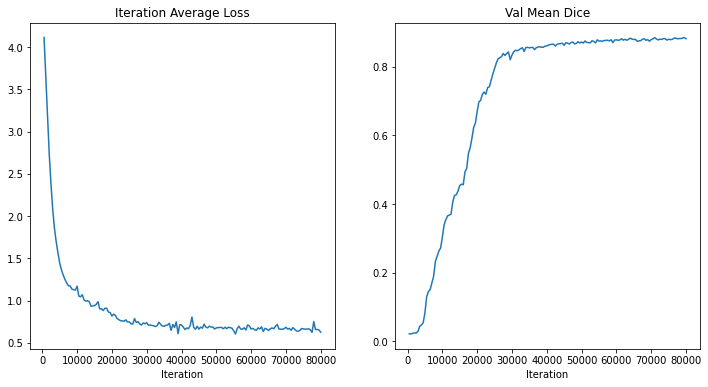

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

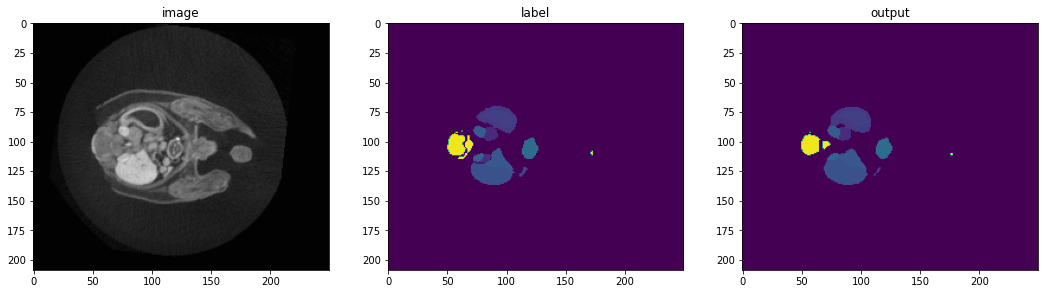

In [8]:
case_num = 5
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_largePatch.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (128, 128, 128), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

In [18]:
output = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
print(f"output shape: {output.shape}")
print(f"output max: {output.max()}")
print(f"output max: {output.min()}")
print(slice_map[img_name])

output shape: torch.Size([209, 250, 400])
output max: 50
output max: 0
140


In [19]:
torch.save(output, "./out/AAMN_N305_26.nii.gz")

### Cleanup data directory

Remove directory if a temporary was used.

In [18]:
if directory is None:
    shutil.rmtree(root_dir)